In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from datetime import datetime
from src.support_class import *
from src.objComposite import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [2]:
def load_date(job_dir, theta, phi):
    t_headle = 'th%5.3f_ph%5.3f_(.*?).pickle' % (theta, phi)
    # t_path = os.listdir(os.path.join(PWD, job_dir))
    filename = [filename for filename in os.listdir(os.path.join(PWD, job_dir))
                if re.match(t_headle, filename) is not None][0]
    with open(os.path.join(PWD, job_dir, filename), 'rb') as handle:
        tpick = pickle.load(handle)
    return tpick, filename

/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:12: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


True

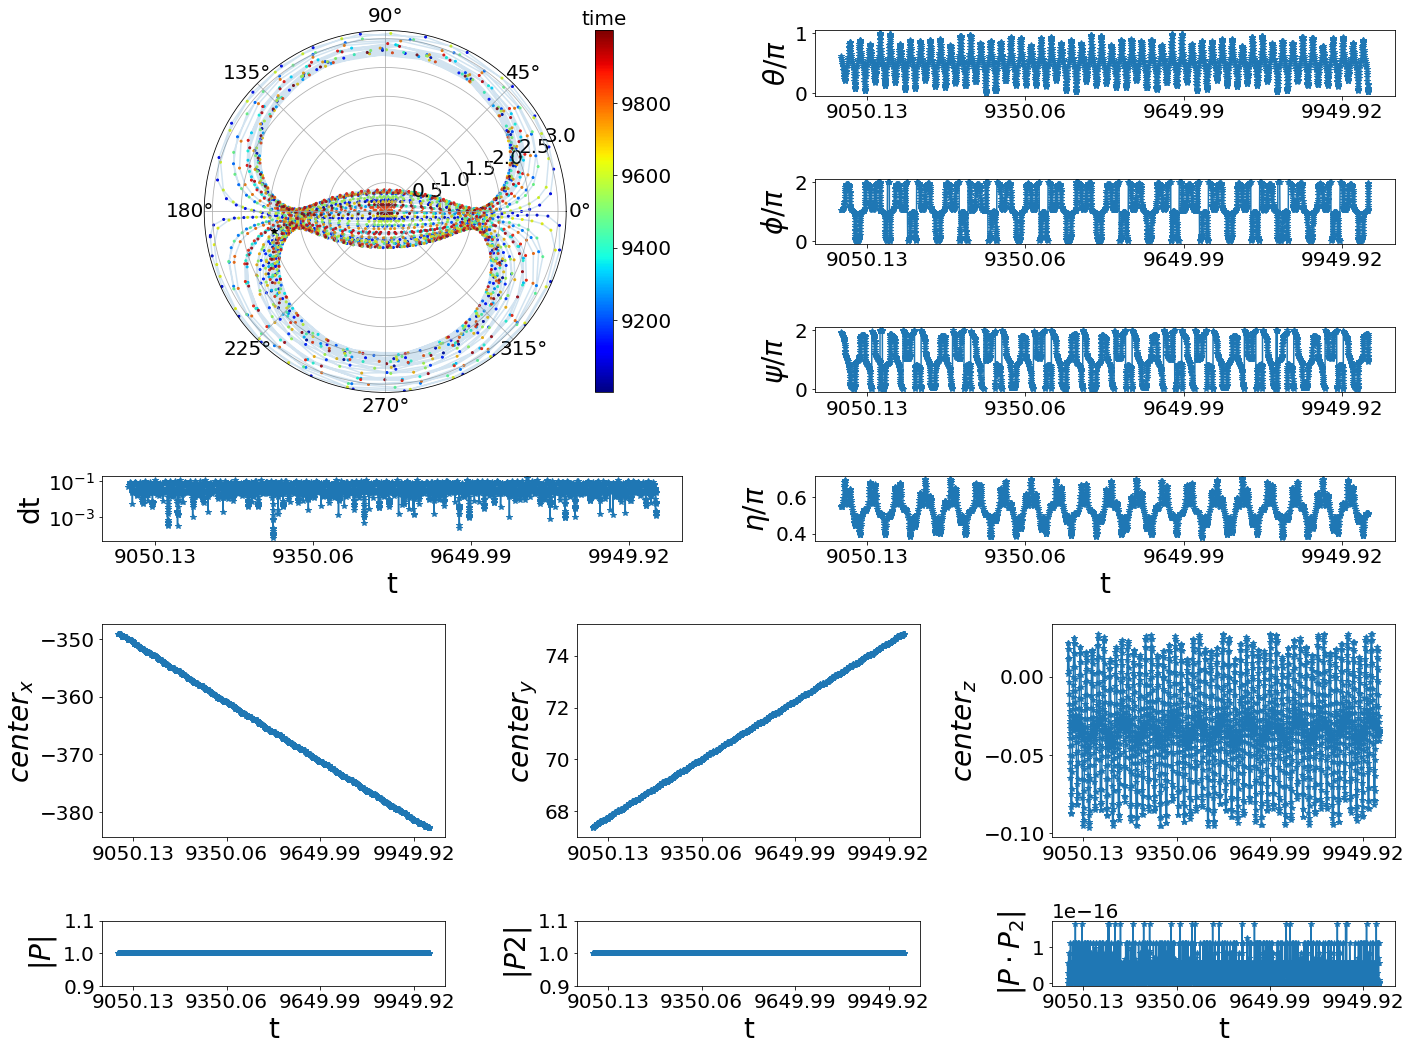

In [49]:
importlib.reload(spf_tb)
job_dir = 'hlxC01_a_psi-0b'
theta, phi = 1.047, 3.094

tpick, filename = load_date(job_dir, theta, phi)
for var_name in tpick.keys():
    texp = '%s = tpick[\'%s\']' % (var_name, var_name)
    exec(texp)
if 'Table_dt' not in tpick.keys():
    Table_dt = np.hstack((np.diff(Table_t), 0))

tidx = np.logical_and(Table_t < 10000, Table_t > 9000)
# tidx = np.arange(Table_t.size)
spf_tb.show_table_result(Table_t[tidx], Table_dt[tidx], Table_X[tidx], Table_P[tidx], Table_P2[tidx], 
                         Table_theta[tidx], Table_phi[tidx], Table_psi[tidx], Table_eta[tidx], save_every, 
                         )
# anim = spf_tb.make_table_video(Table_t[tidx], Table_X[tidx], Table_P[tidx], Table_P2[tidx],
#                                Table_theta[tidx], Table_phi[tidx], Table_psi[tidx], Table_eta[tidx],
#                                zm_fct=30, stp=1, interval=50)
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# tname = '%s_th%5.3f_ph%5.3f.mp4' % ('dbg', theta, phi)
# anim.save(tname, writer='ffmpeg', fps=15)
# print('finish', datetime.now())

/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:12: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


trange_geo= 5.69234600132608
trange_trj= 70


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


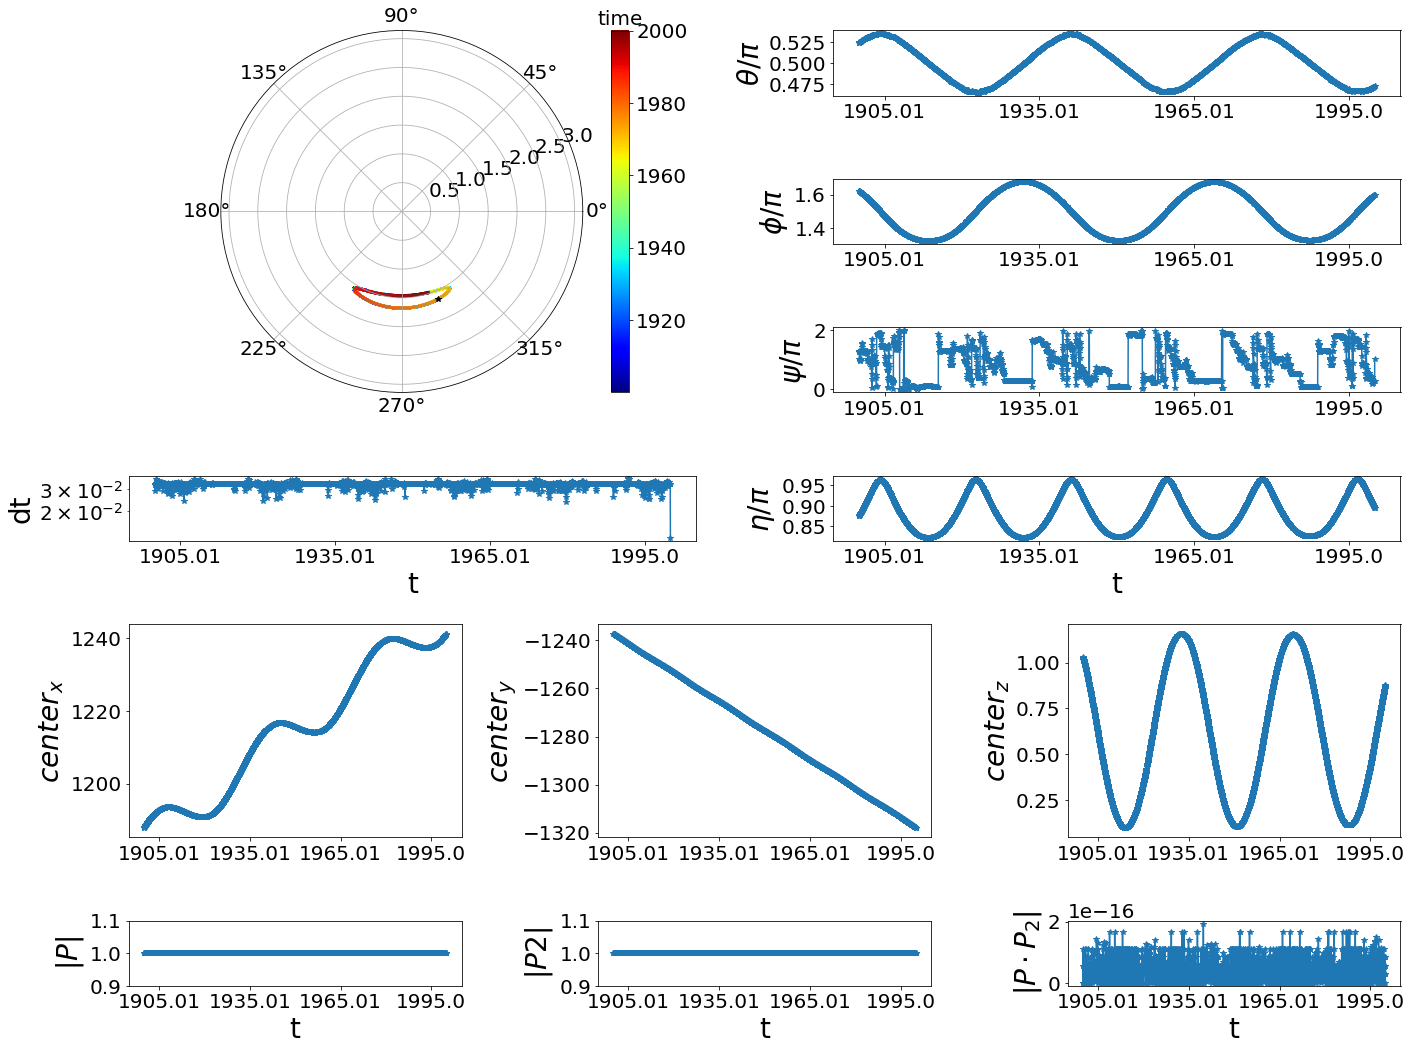

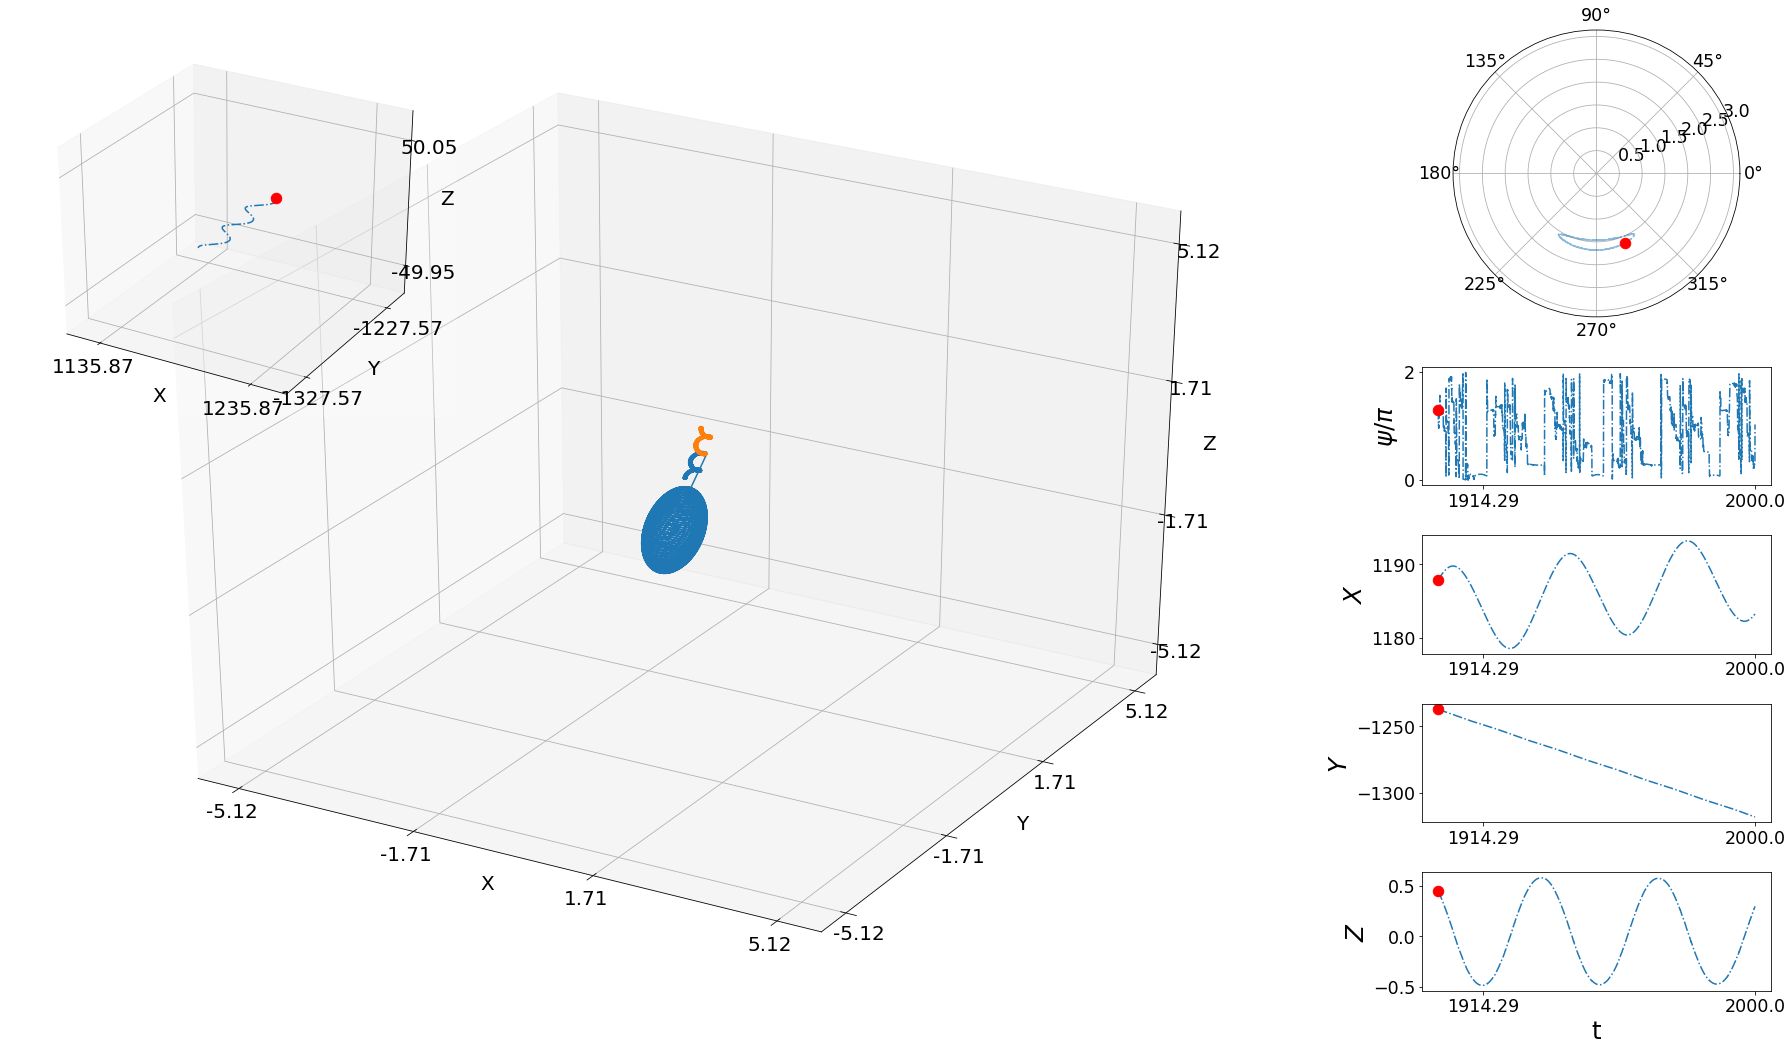

In [41]:
importlib.reload(spf_tb)

job_dir = 'ecoliB01_a'
theta, phi = 0, 0.134
pickle_name = 'planeShearRatex_1c_kwargs'
create_obj_at_fun = get_ecoli_nodes_split_at

# job_dir = 'hlxC01_a_psi-0b'
# theta, phi = 2.094, 3.473
# pickle_name = 'hlxC01_tau1a_kwargs'
# create_obj_at_fun = get_tail_nodes_split_at

# job_dir = 'hlxC01_a_psi-0b'
# theta, phi = 0, 0
# pickle_name = 'hlxC01_tau1a_kwargs'
# create_obj_at_fun = get_tail_nodes_split_at

# job_dir = 'hlxC01_a_psi-0b'
# theta, phi = 0.698, 6.125
# pickle_name = 'hlxC01_tau1a_kwargs'
# create_obj_at_fun = get_tail_nodes_split_at

# job_dir = 'hlxC01_a_psi-0b'
# theta, phi = 1.745, 6.252
# pickle_name = 'hlxC01_tau1a_kwargs'
# create_obj_at_fun = get_tail_nodes_split_at

tpick, filename = load_date(job_dir, theta, phi)
for var_name in tpick.keys():
    texp = '%s = tpick[\'%s\']' % (var_name, var_name)
    exec(texp)
if 'Table_dt' not in tpick.keys():
    Table_dt = np.hstack((np.diff(Table_t), 0))
problem_kwargs = spf_tb.load_problem_kwargs(pickle_name)

tidx = np.logical_and(Table_t < 10000, Table_t > 1900)
# tidx = np.arange(Table_t.size)
spf_tb.show_table_result(Table_t[tidx], Table_dt[tidx], Table_X[tidx], Table_P[tidx], Table_P2[tidx], 
                         Table_theta[tidx], Table_phi[tidx], Table_psi[tidx], Table_eta[tidx], save_every)
# anim = spf_tb.make_table_video(Table_t[tidx], Table_X[tidx], Table_P[tidx], Table_P2[tidx],
#                                    Table_theta[tidx], Table_phi[tidx], Table_psi[tidx], Table_eta[tidx],
#                                    zm_fct=30, stp=1, interval=50, trange=70)
anim = spf_tb.make_table_video_geo(Table_t[tidx], Table_X[tidx], Table_P[tidx], Table_P2[tidx],
                                   Table_theta[tidx], Table_phi[tidx], Table_psi[tidx], Table_eta[tidx],
                                   zm_fct=30, stp=1, interval=50, trange_trj=70, move_z=True, 
                                   create_obj_at_fun=create_obj_at_fun, **problem_kwargs)

# tname = '%s_th%5.3f_ph%5.3f.mp4' % (job_dir, theta, phi)
# anim.save(tname, writer='ffmpeg', fps=15)
# print('save to %s at' % tname, datetime.now())

In [43]:
print('%.16f, %.16f, %.16f' % (Table_theta[-1], Table_phi[-1], Table_psi[-1]))

1.4845661904753169, 5.0281151306960048, 3.2378122439838437


In [51]:
n_psi_lim = 20
np.linspace(0, 2 * np.pi, n_psi_lim * 8, endpoint=False)[::n_psi_lim]

array([0.     , 0.7854 , 1.5708 , 2.35619, 3.14159, 3.92699, 4.71239, 5.49779])

In [42]:
len(info_list)

10

## version 2

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4393947720186036


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 17:21:42.544065 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_stuck_0.43_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4420623309241731


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 17:52:00.525487 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_stuck_0.89_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g/th2.17428_ph5.98741_ps3.66493/omega_tail00.81259_th2.174_ph5.987_ps3.665_D20200812_T210328.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4840902651930428


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 18:21:33.186769 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_stuck_1.43_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.442062330924043


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 18:52:09.340932 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_stuck_1.89_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_w0_psi_rada_a_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4324616737875642


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 19:20:19.983596 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_I1_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_w2_psi_rada_b_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4354861872331106


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 19:49:21.023855 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_I2_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c1_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4442669067275524


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 20:17:33.528642 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II0_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c2_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4454976171896299


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 20:45:50.937233 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II1_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c3_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4758802689468817


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 21:13:55.731790 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II2a_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d2_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4821034138657028


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 21:42:05.045849 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II2b_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d3_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4390239680050403


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 22:10:46.949538 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II2c_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c4_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4406013101157396


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 22:38:53.038999 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II3_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d1_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.444763748728743


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 23:07:21.041770 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II4a_bodyC.mp4

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt2_psi_rada_e_00.pickle


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1986: UserWarning: total_frame is 1200, resampling_fct is IGNORED
  else:
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:1585: UserWarning: size of t_use is 1200, resampling_fct is IGNORED
  warnings.warn(war_msg)


trange_geo= 1.4397565425247567


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2093: UserWarning: size of Table_t is 1200, total_frame is 1200, stp is set to 1
  war_msg = 'size of Table_t is %d, total_frame is %d, stp is set to %d' % \
/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:2098: UserWarning: video_duration is 60.000000, interval is set to 0.050000
  interval = video_duration / frames


2020-08-26 23:35:48.829423 save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_II4b_bodyC.mp4



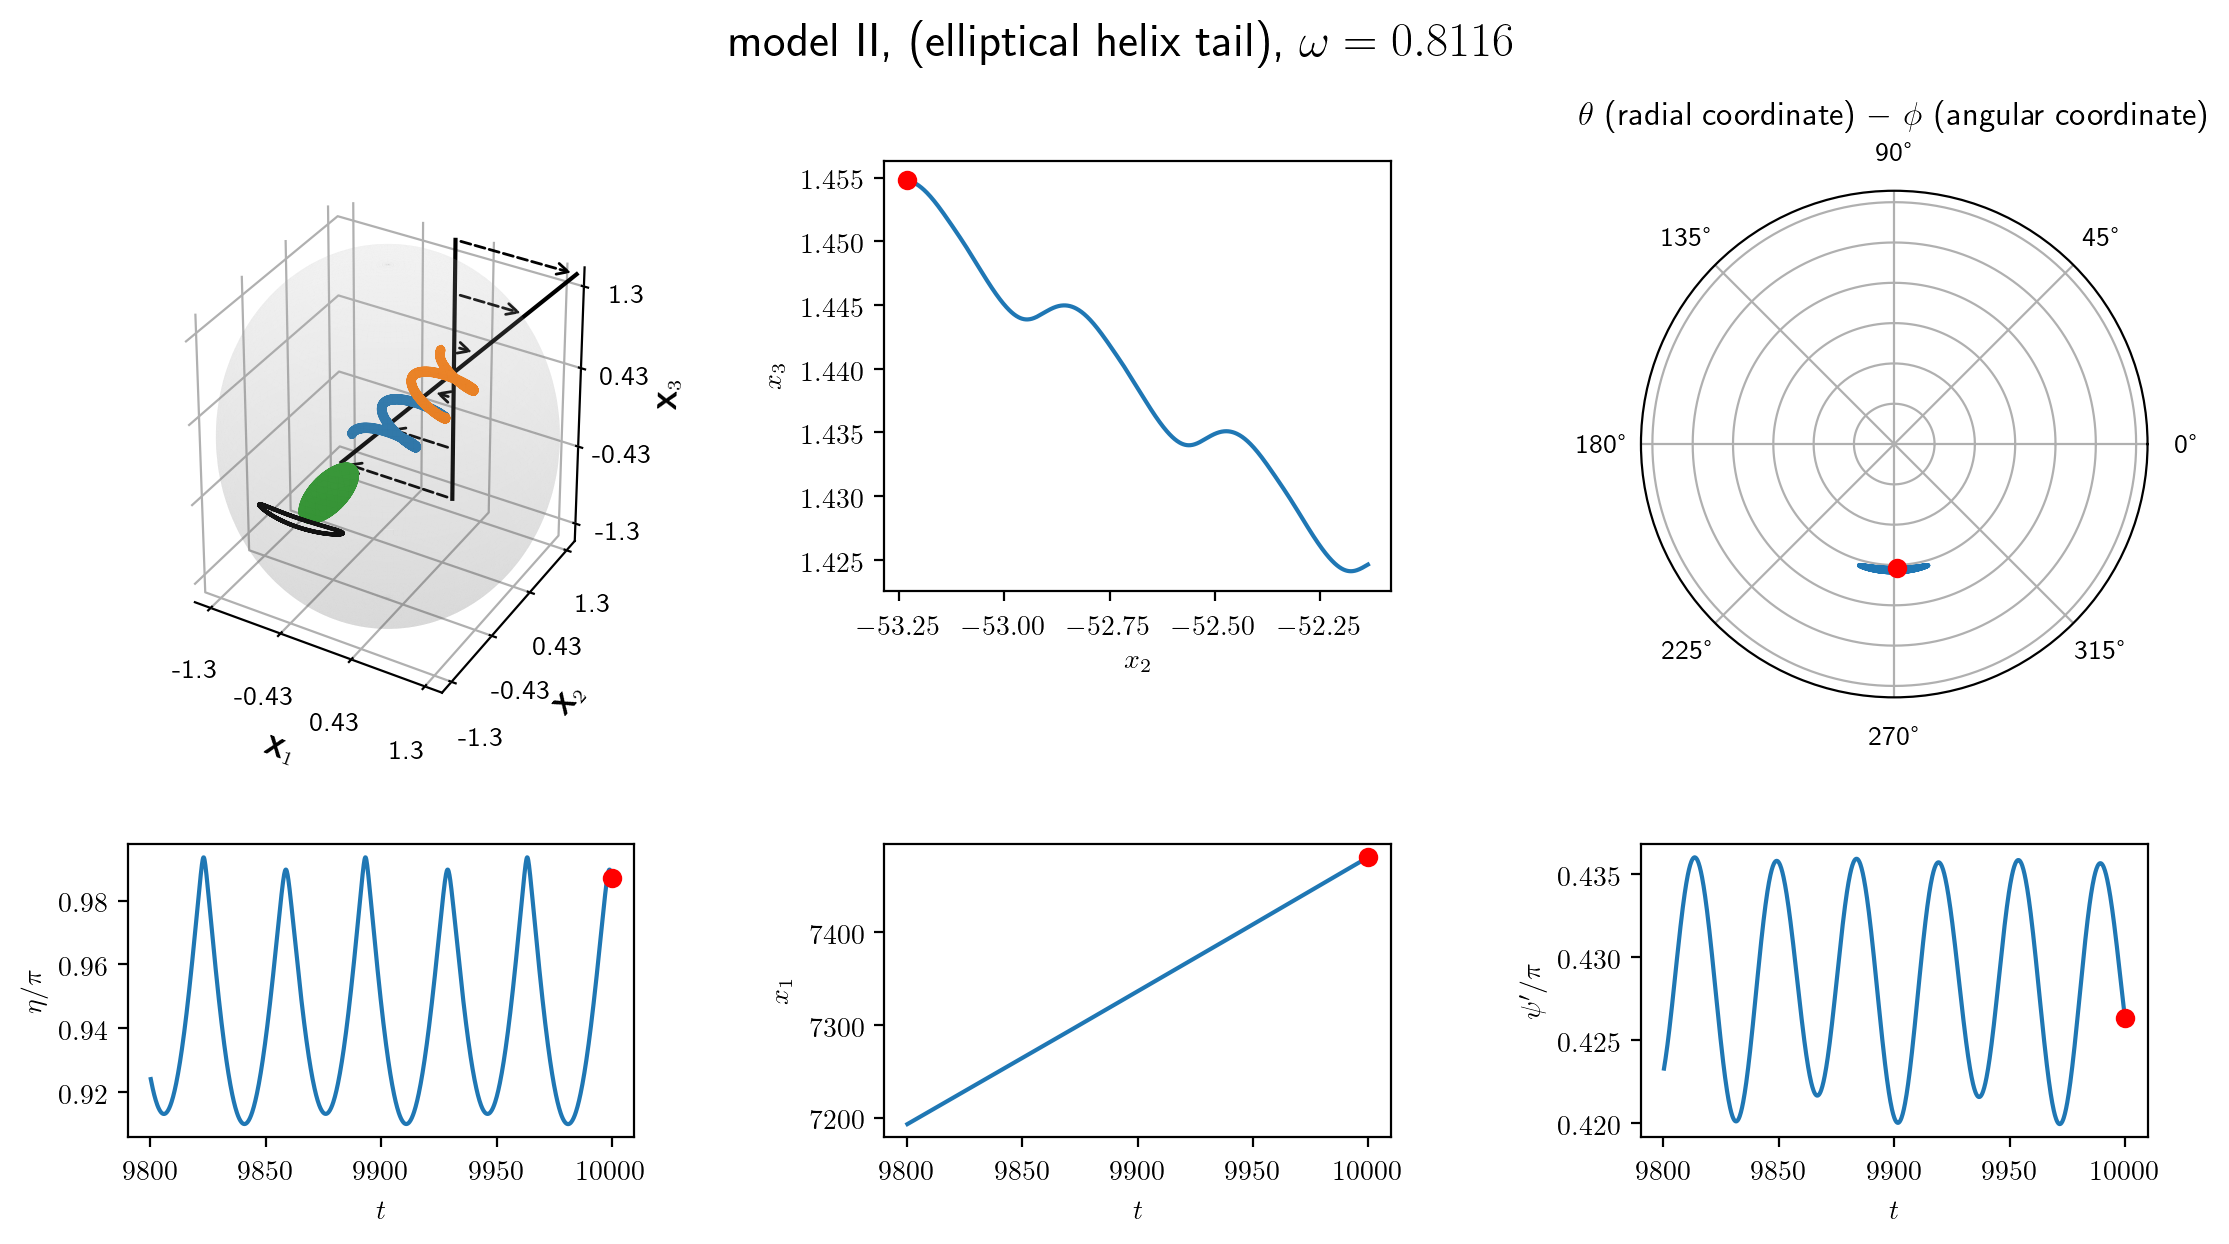

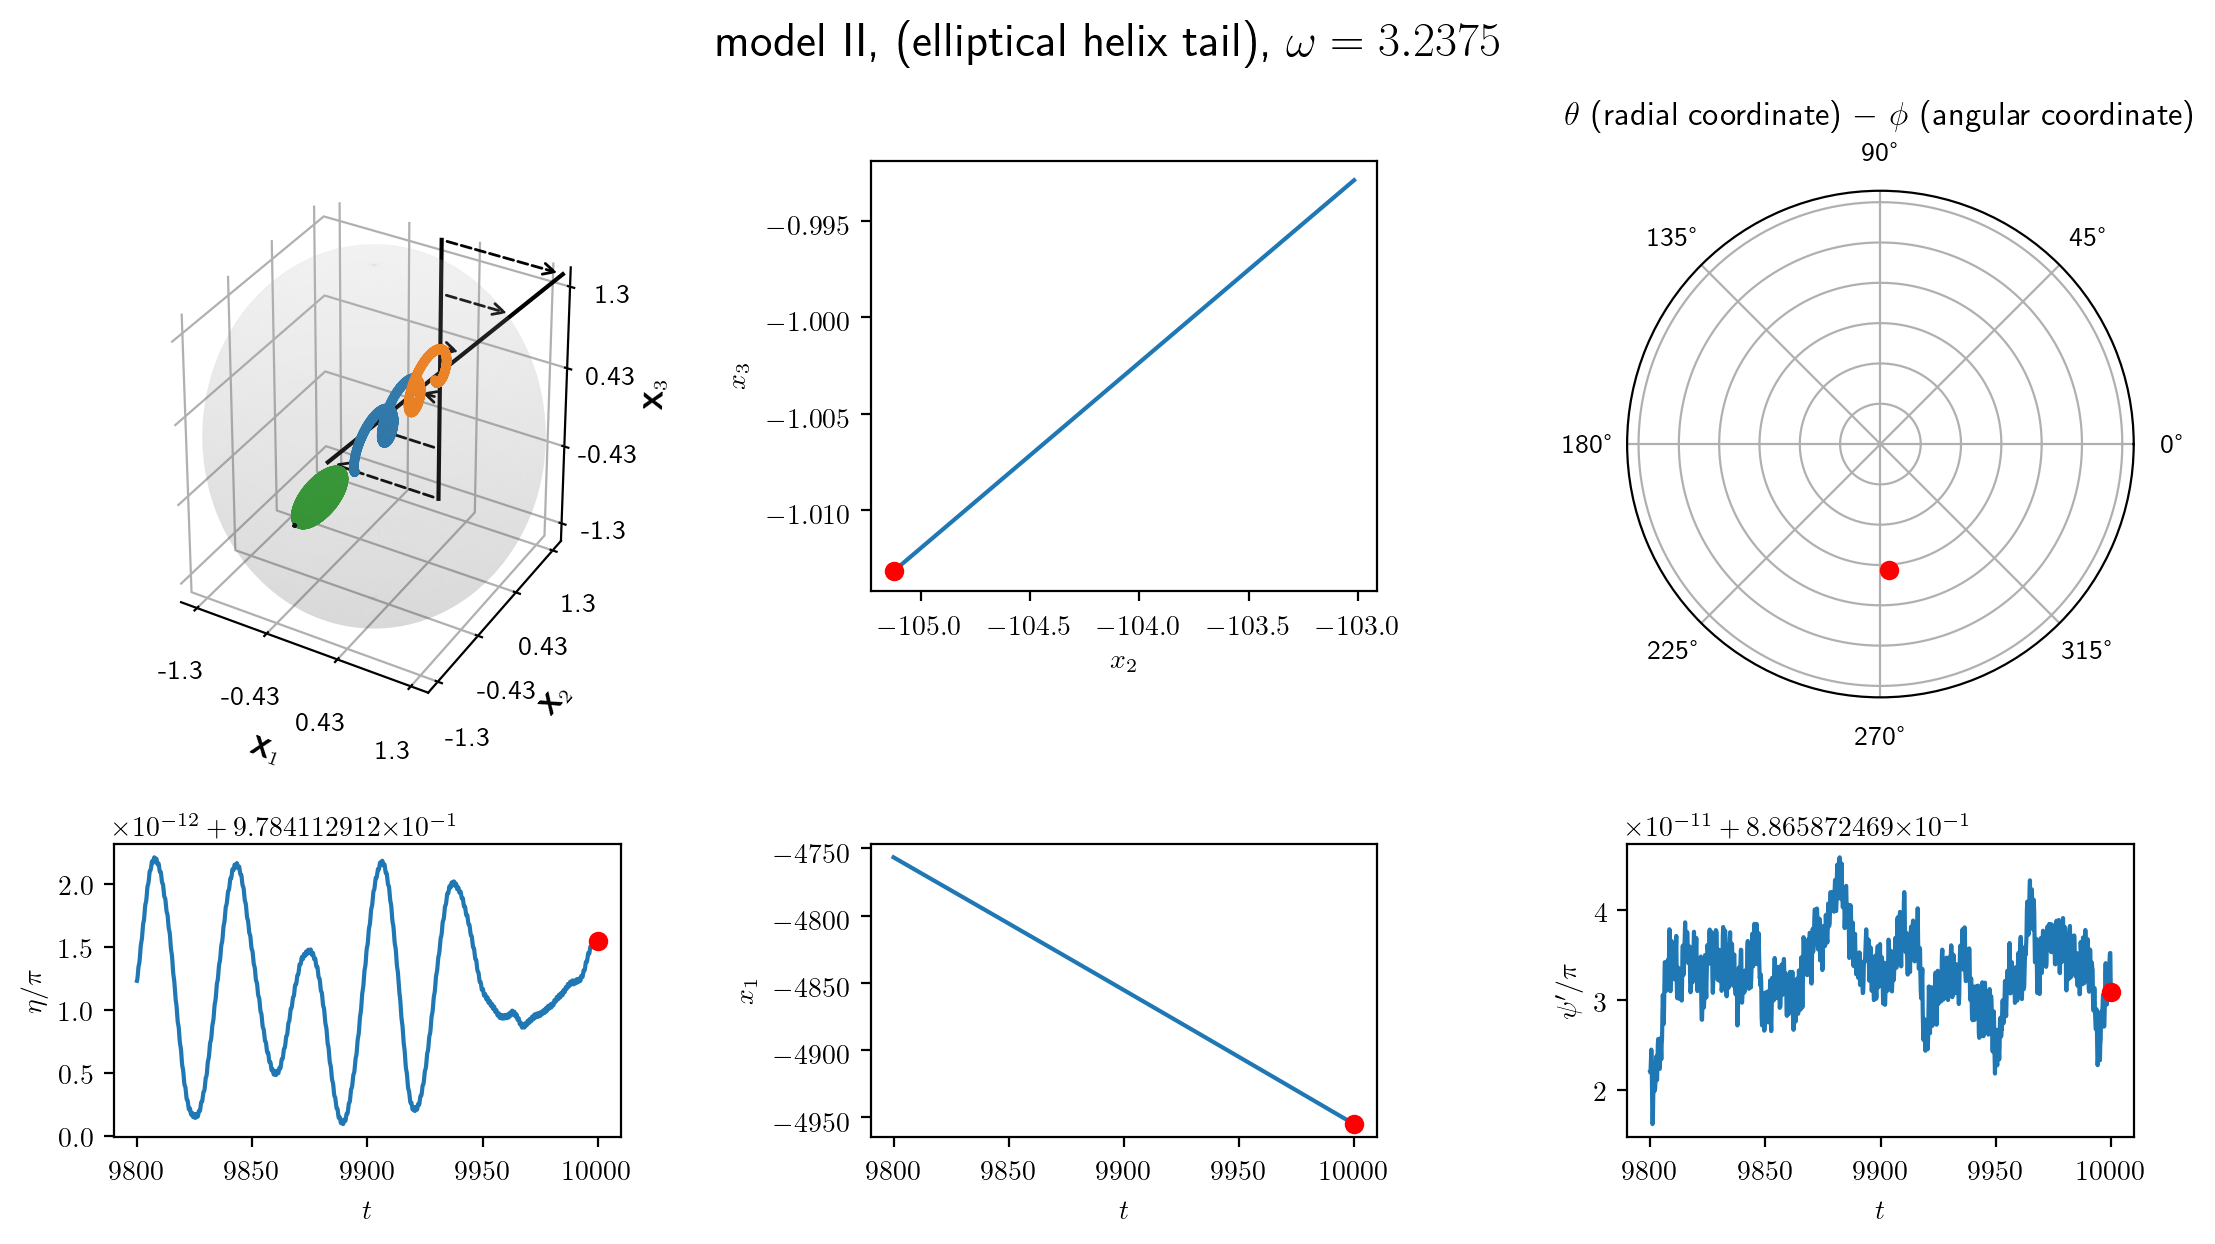

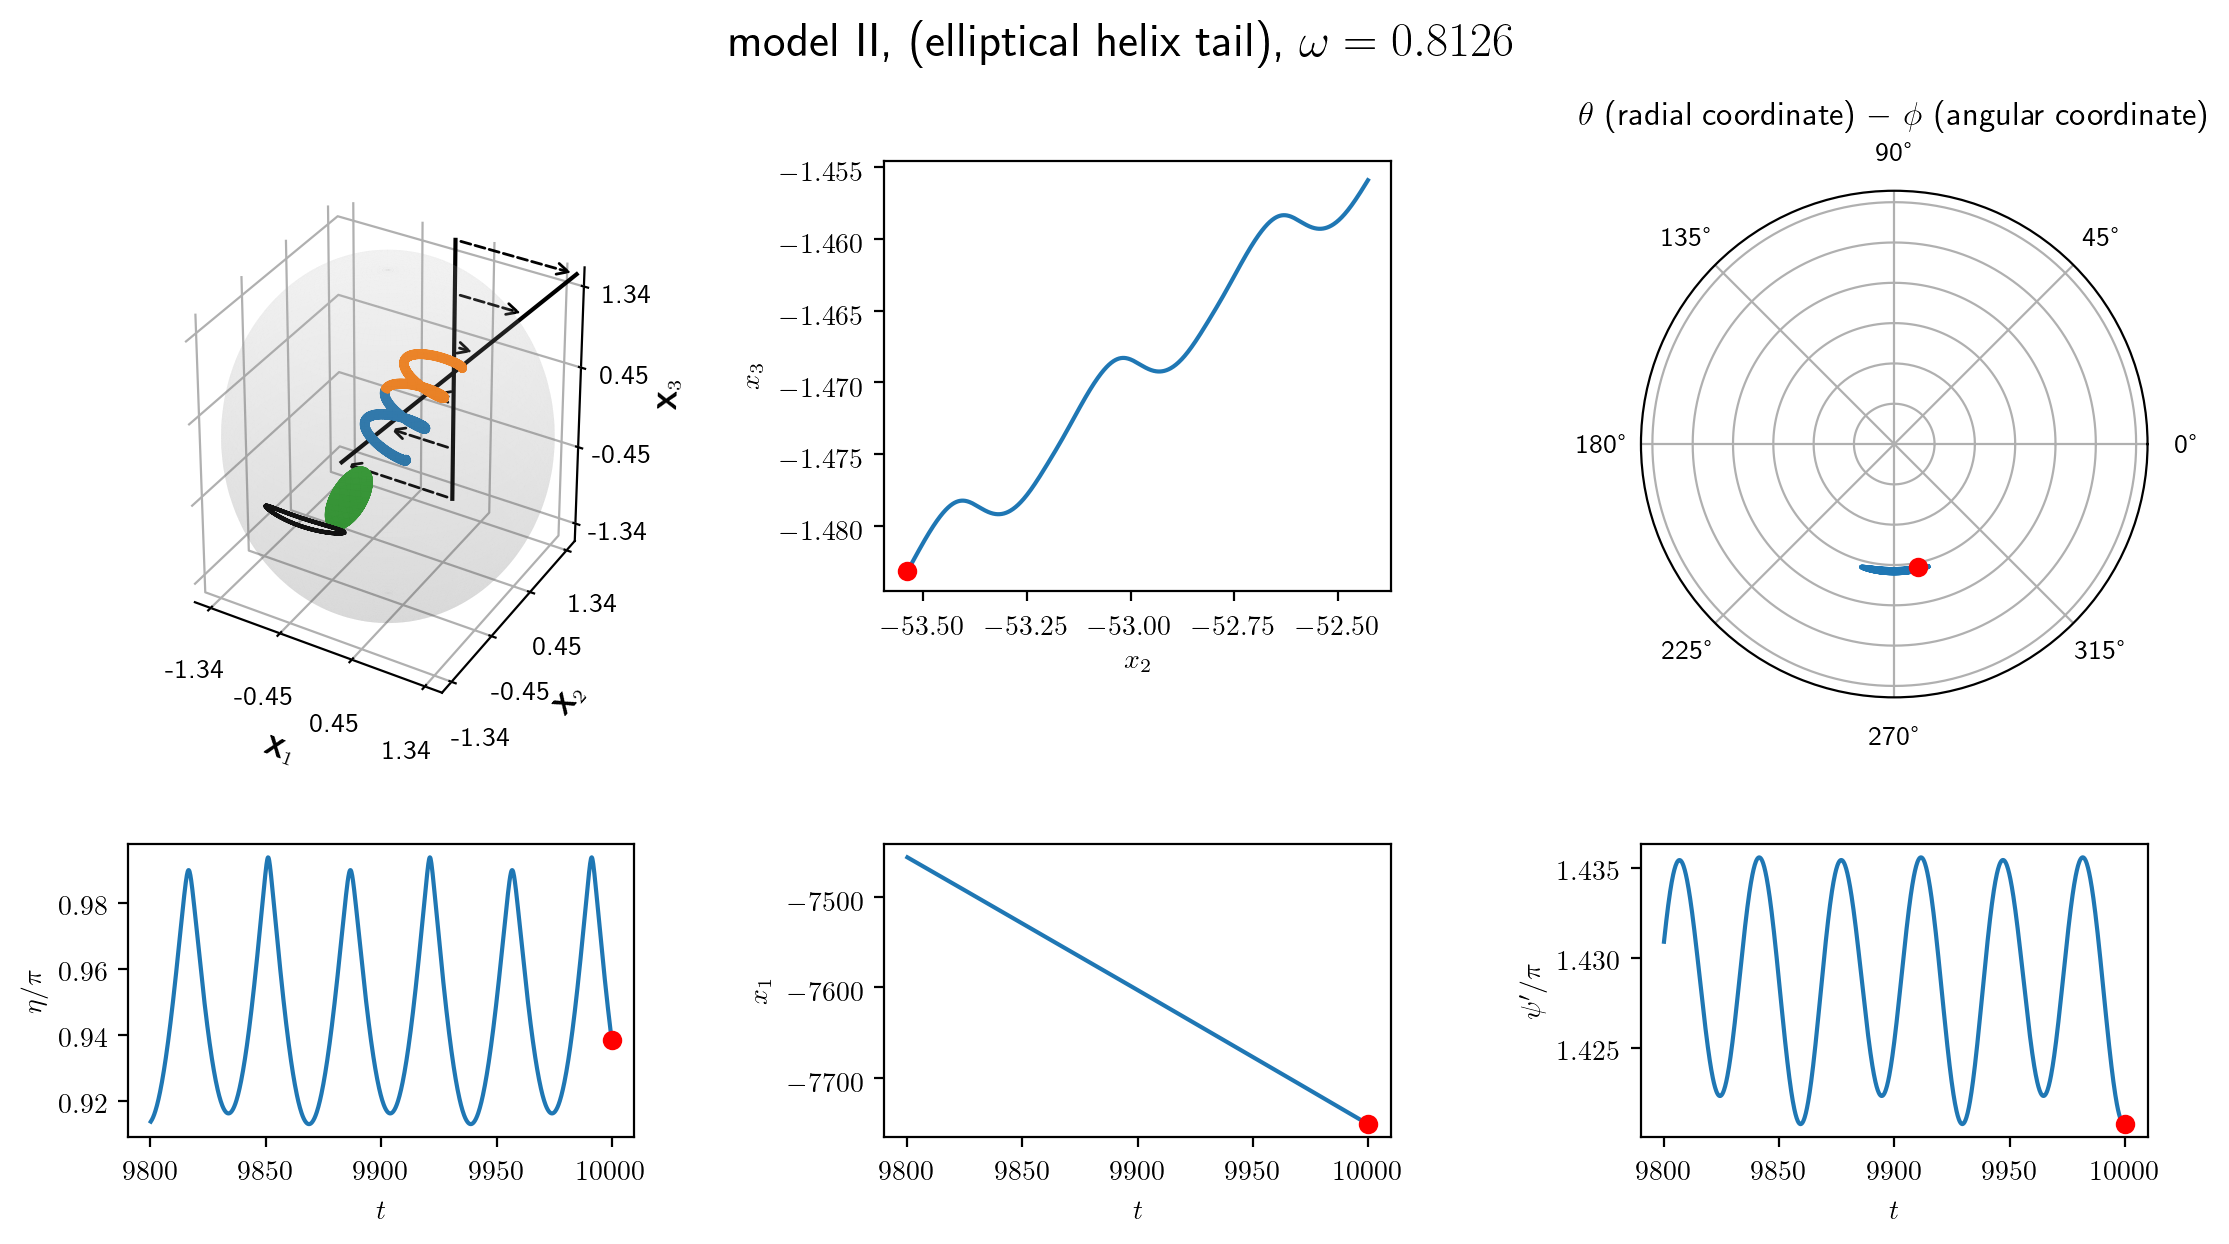

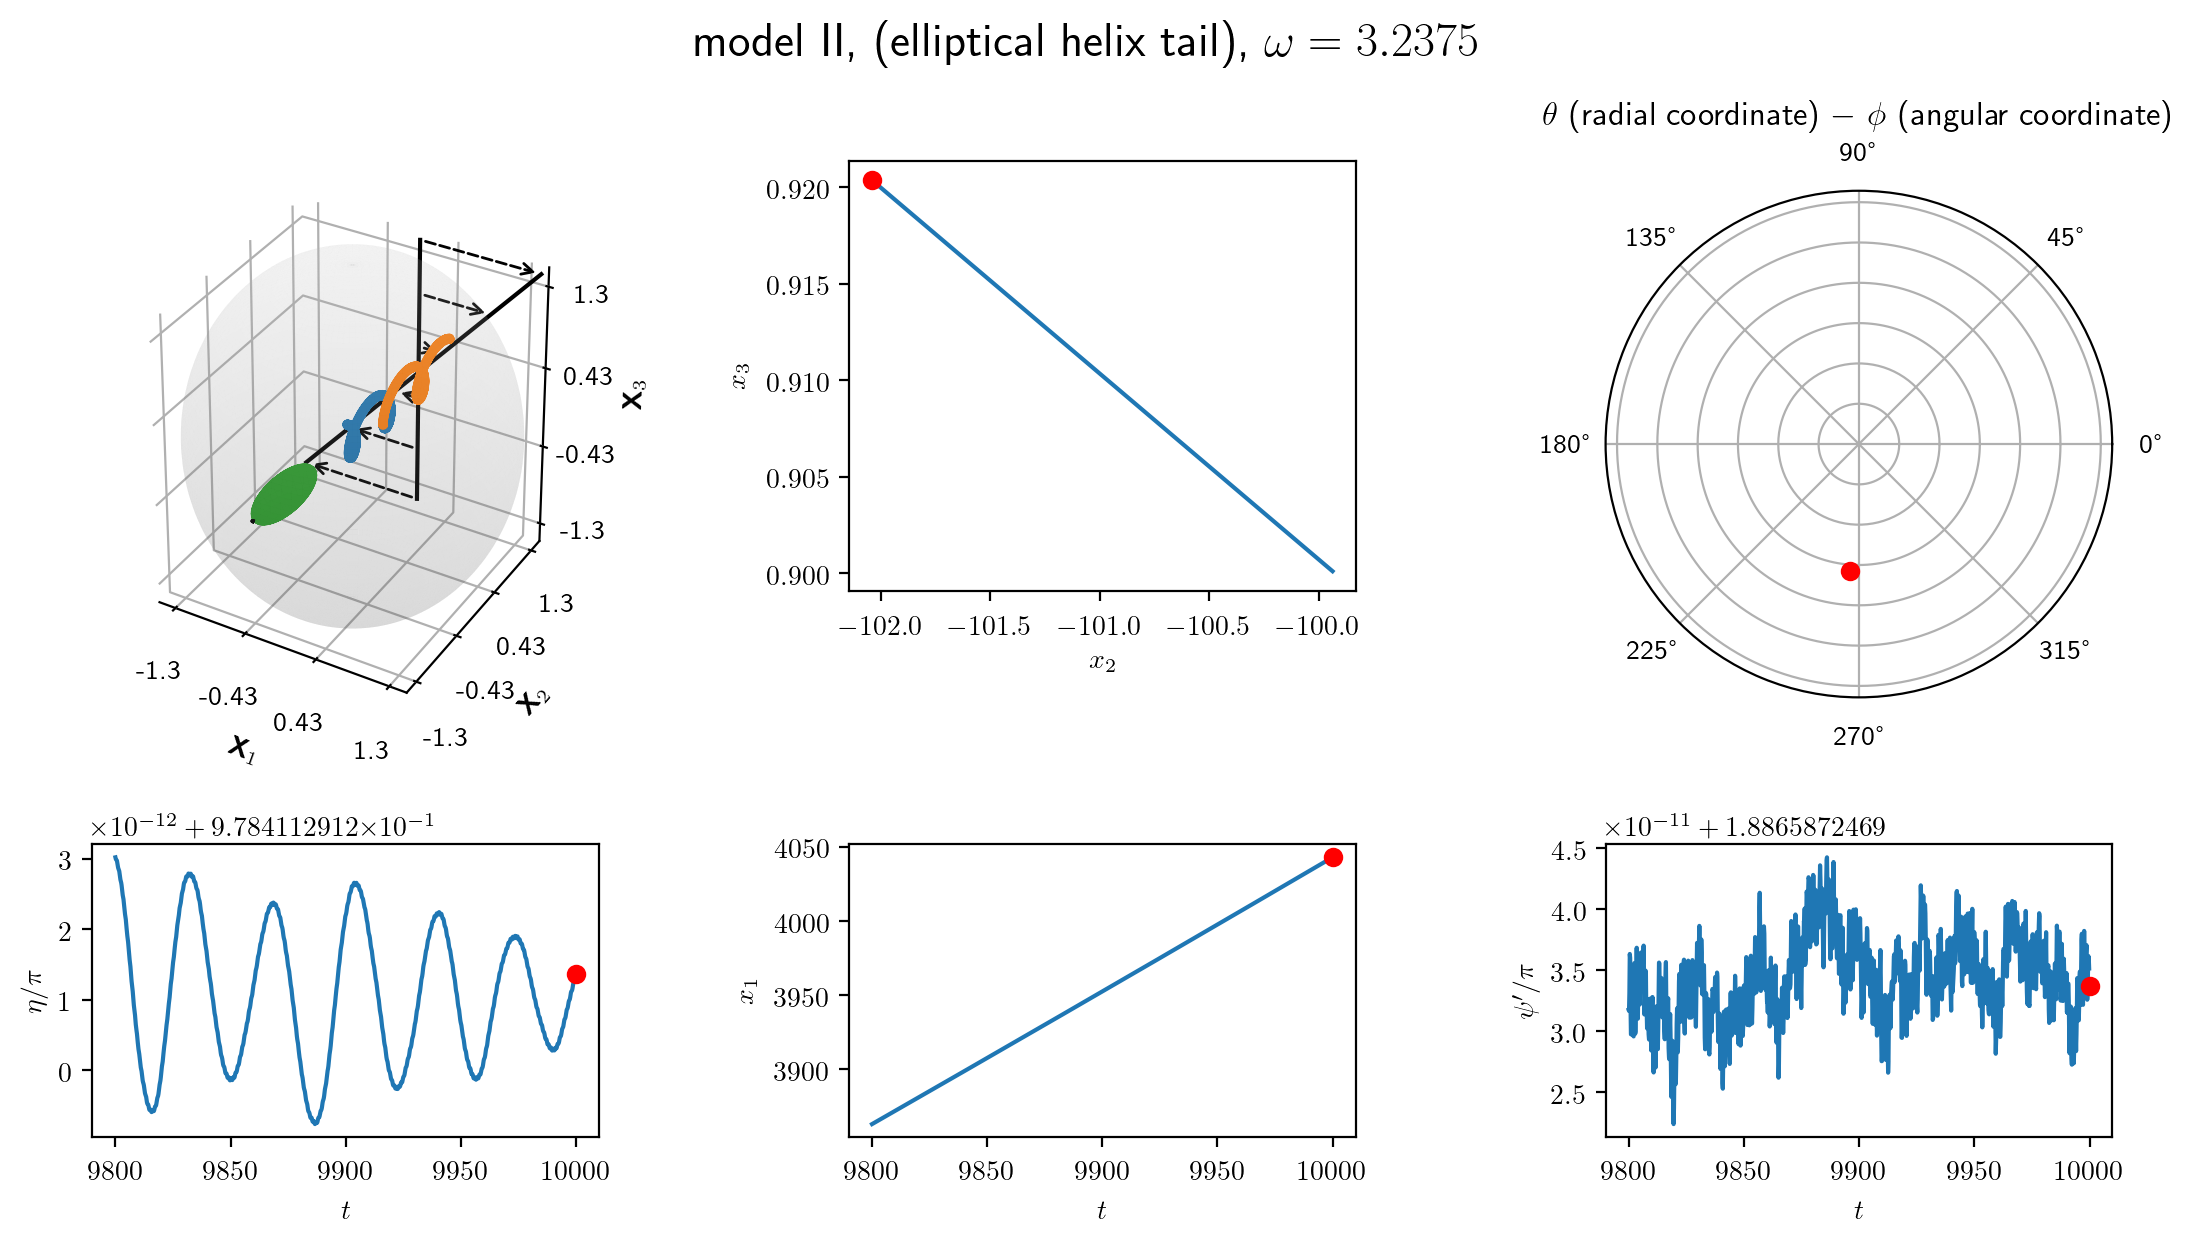

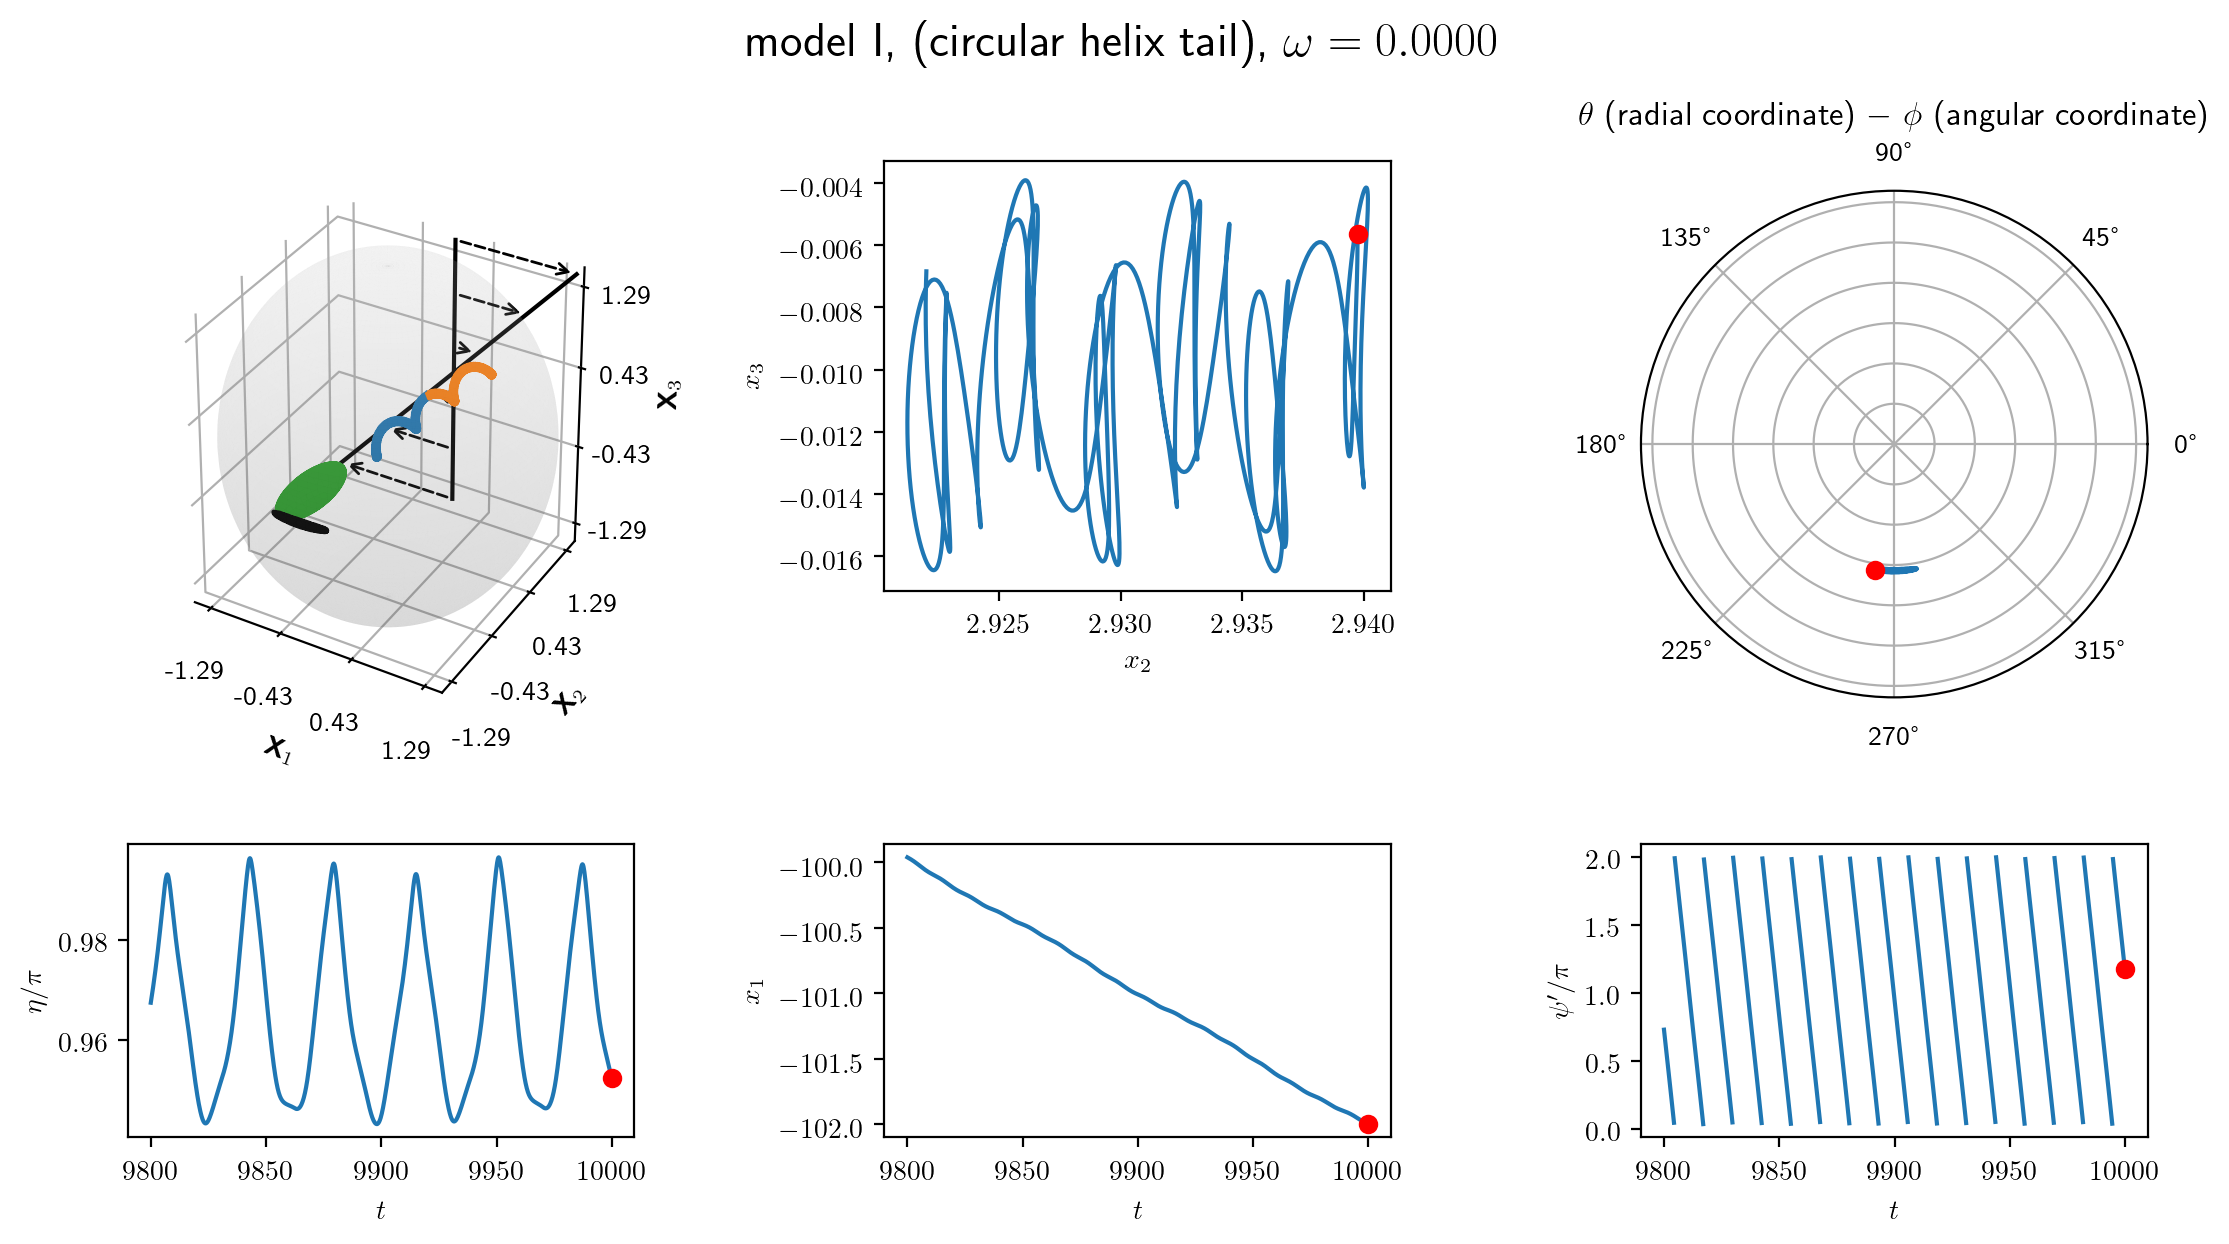

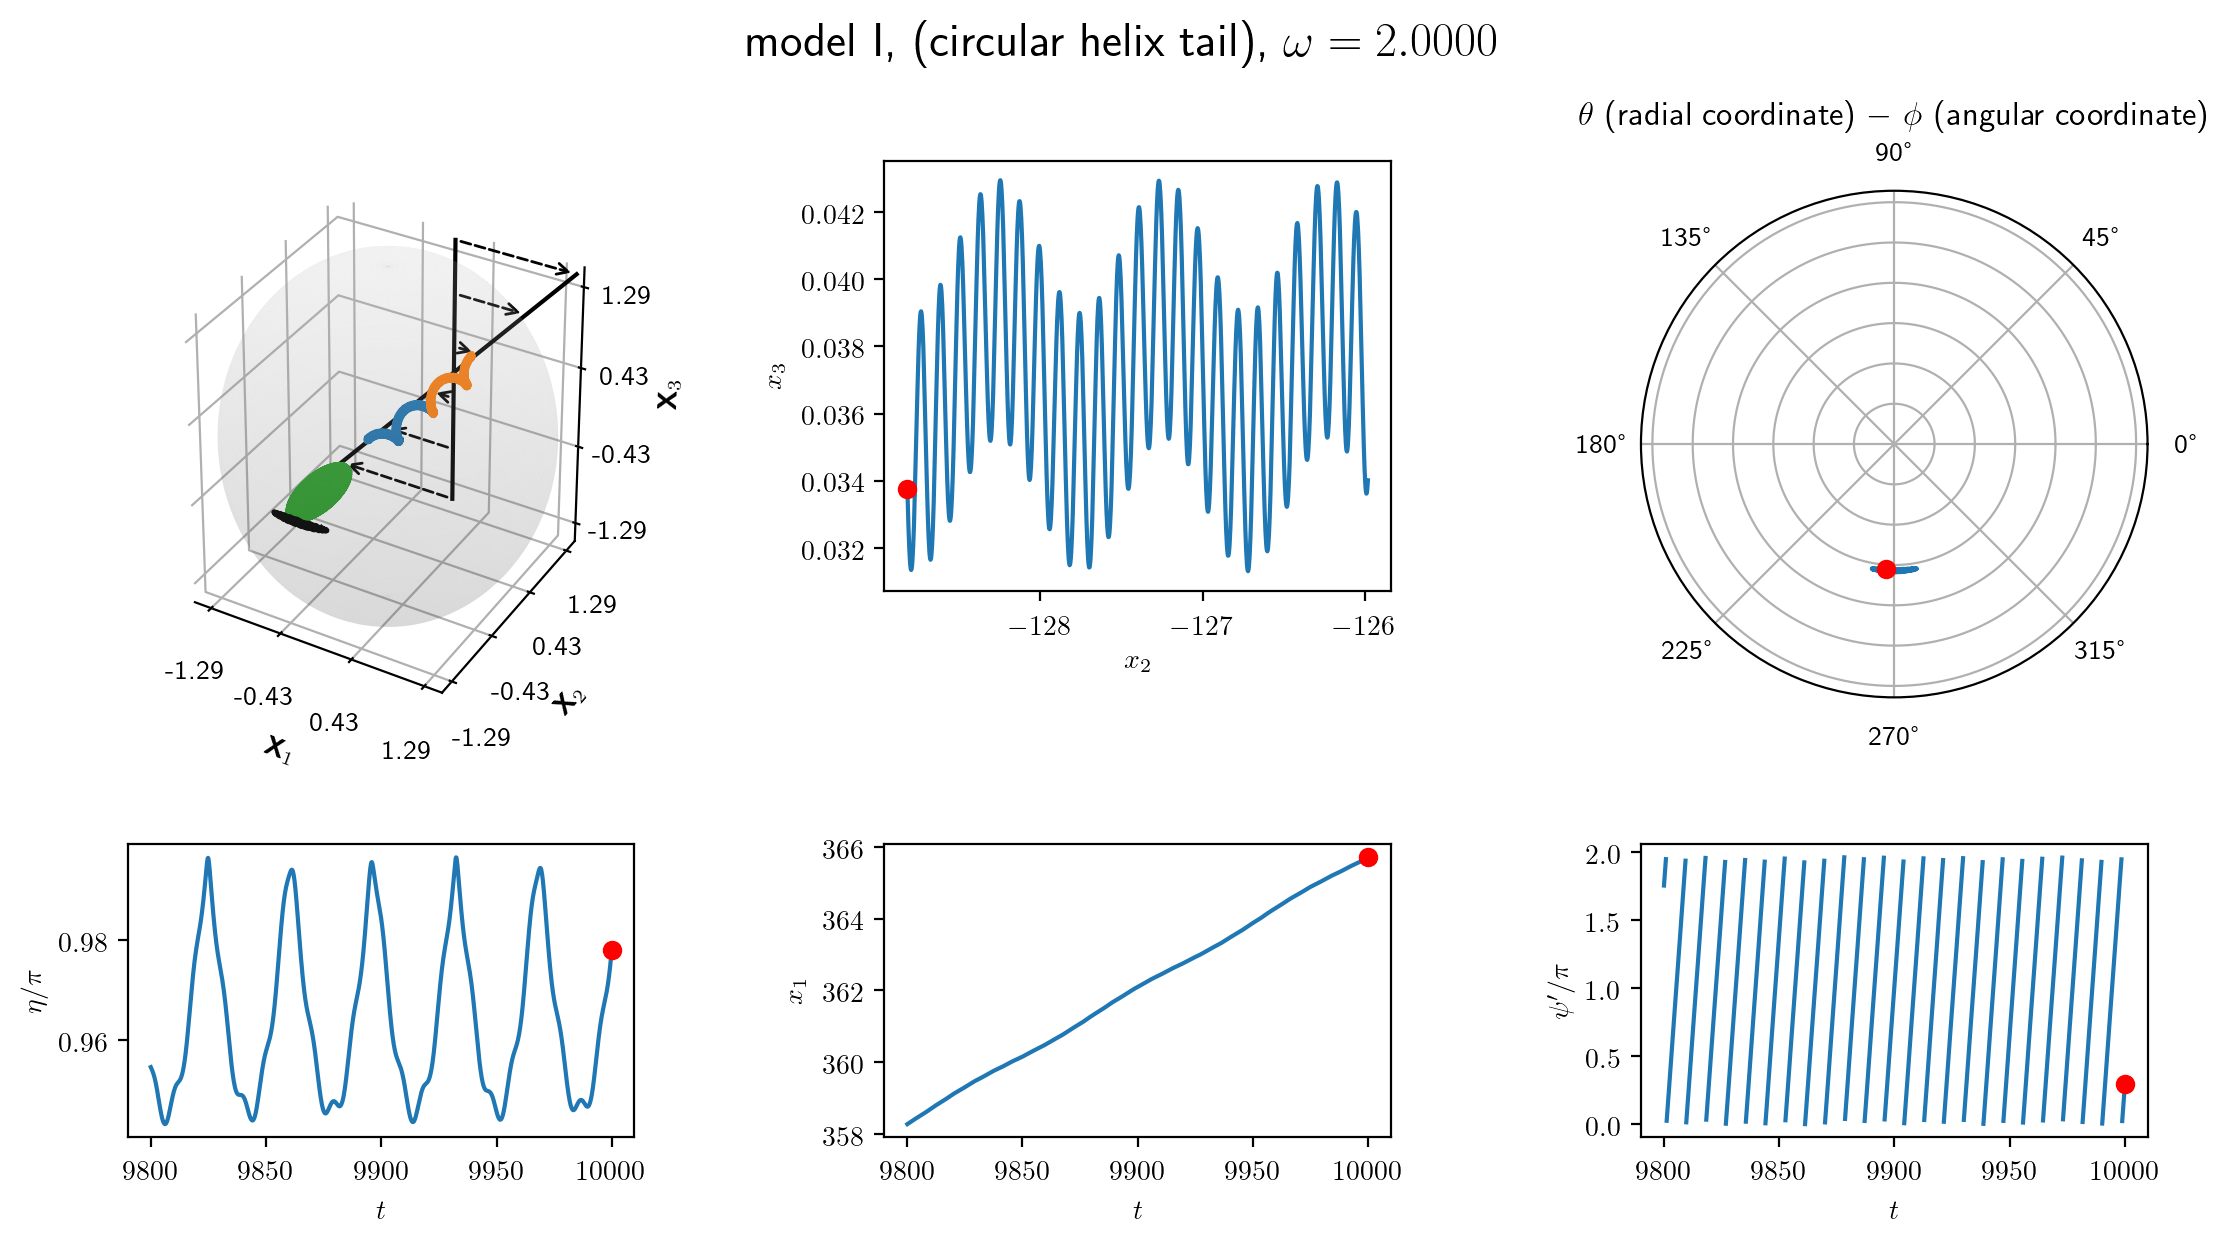

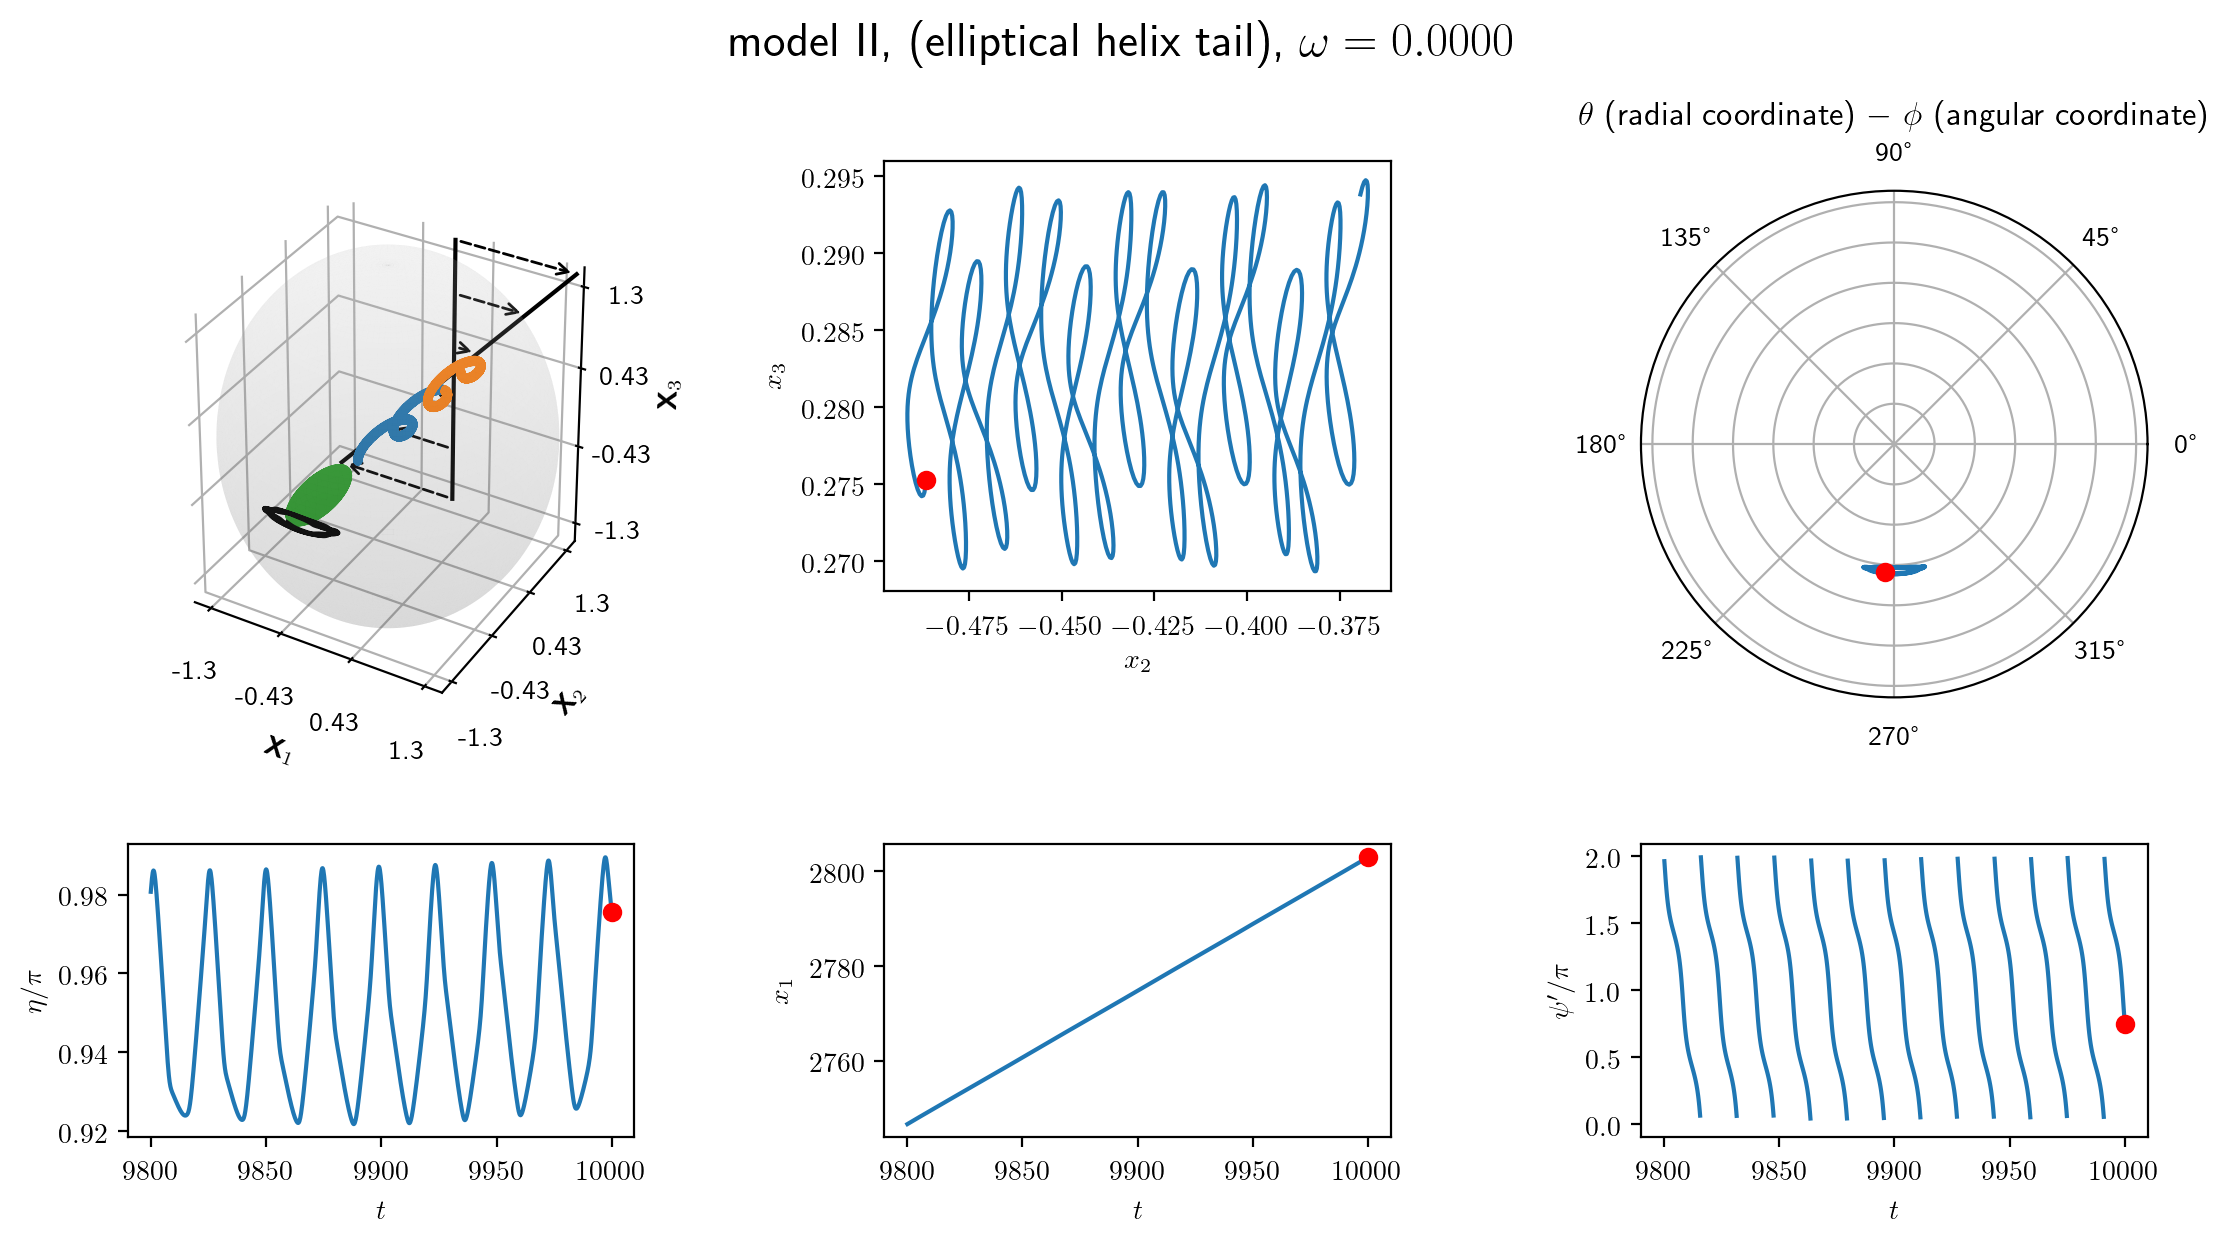

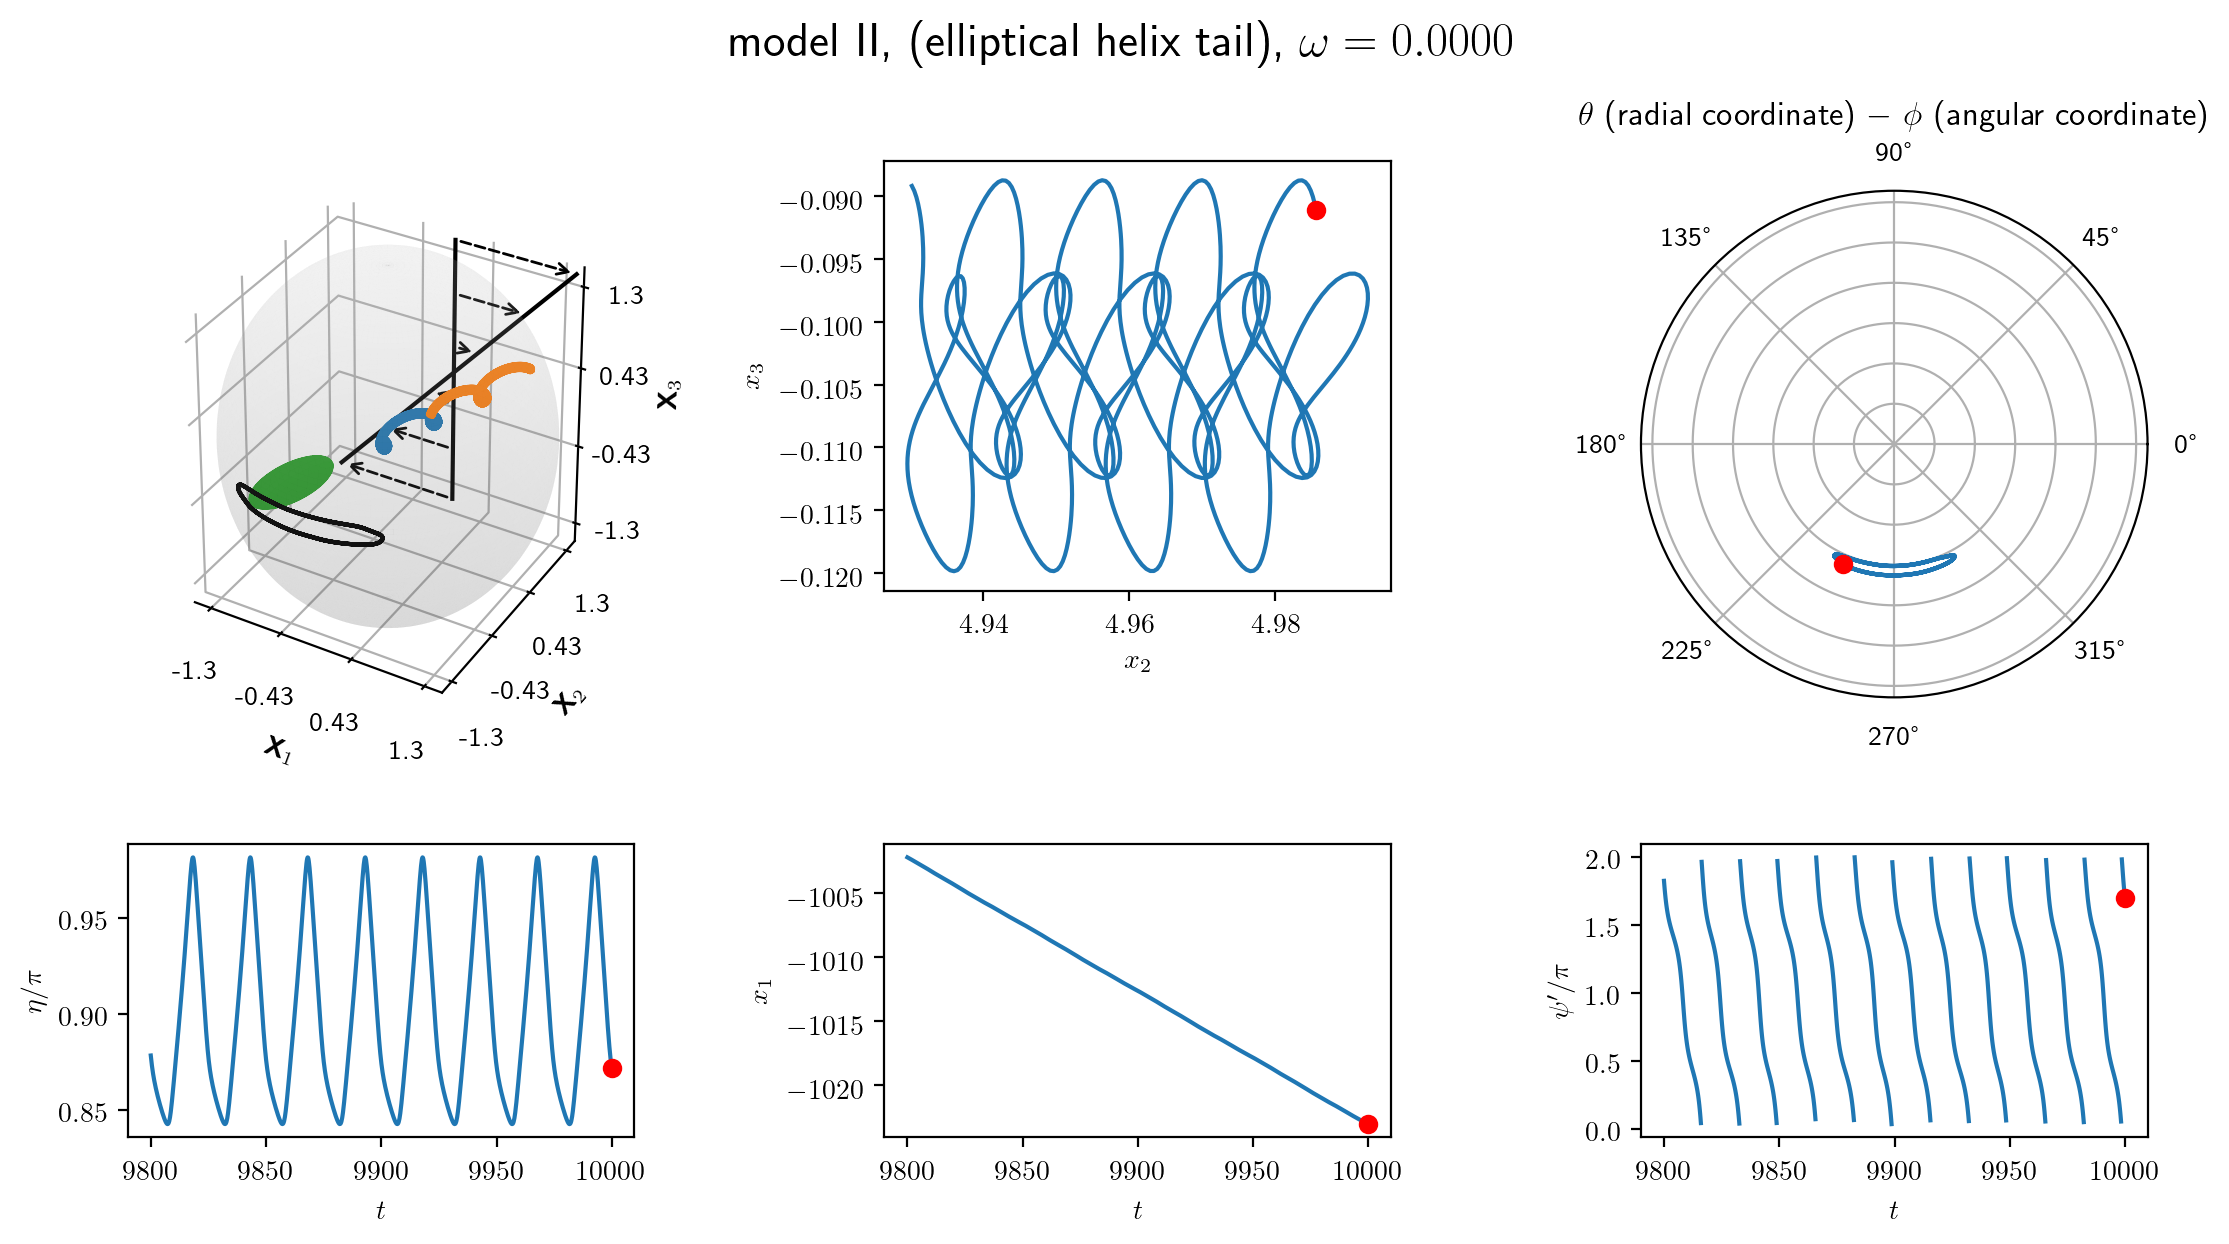

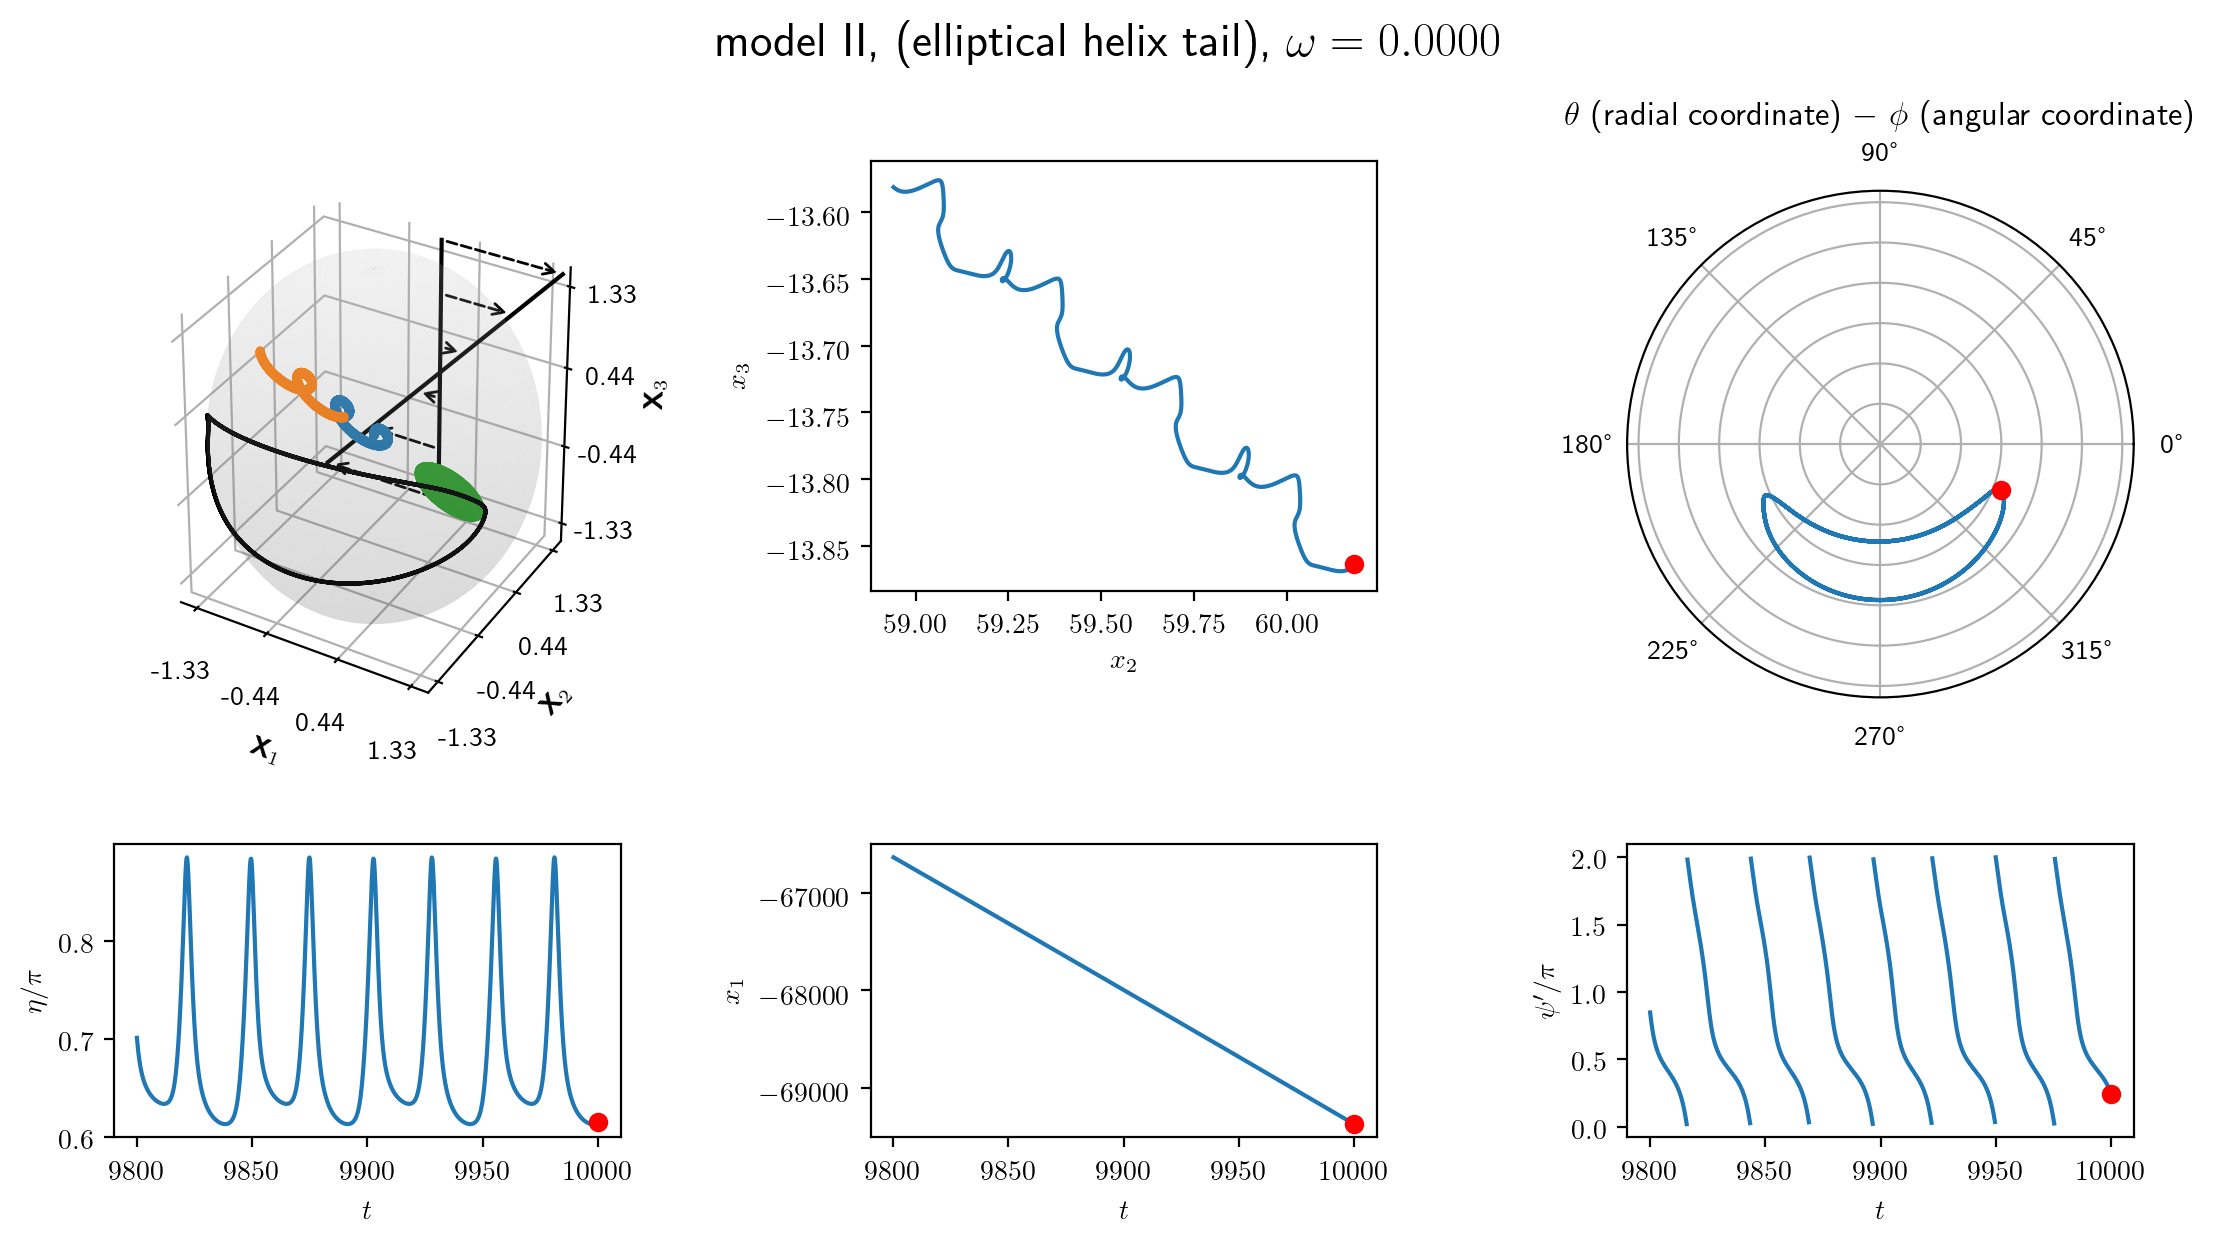

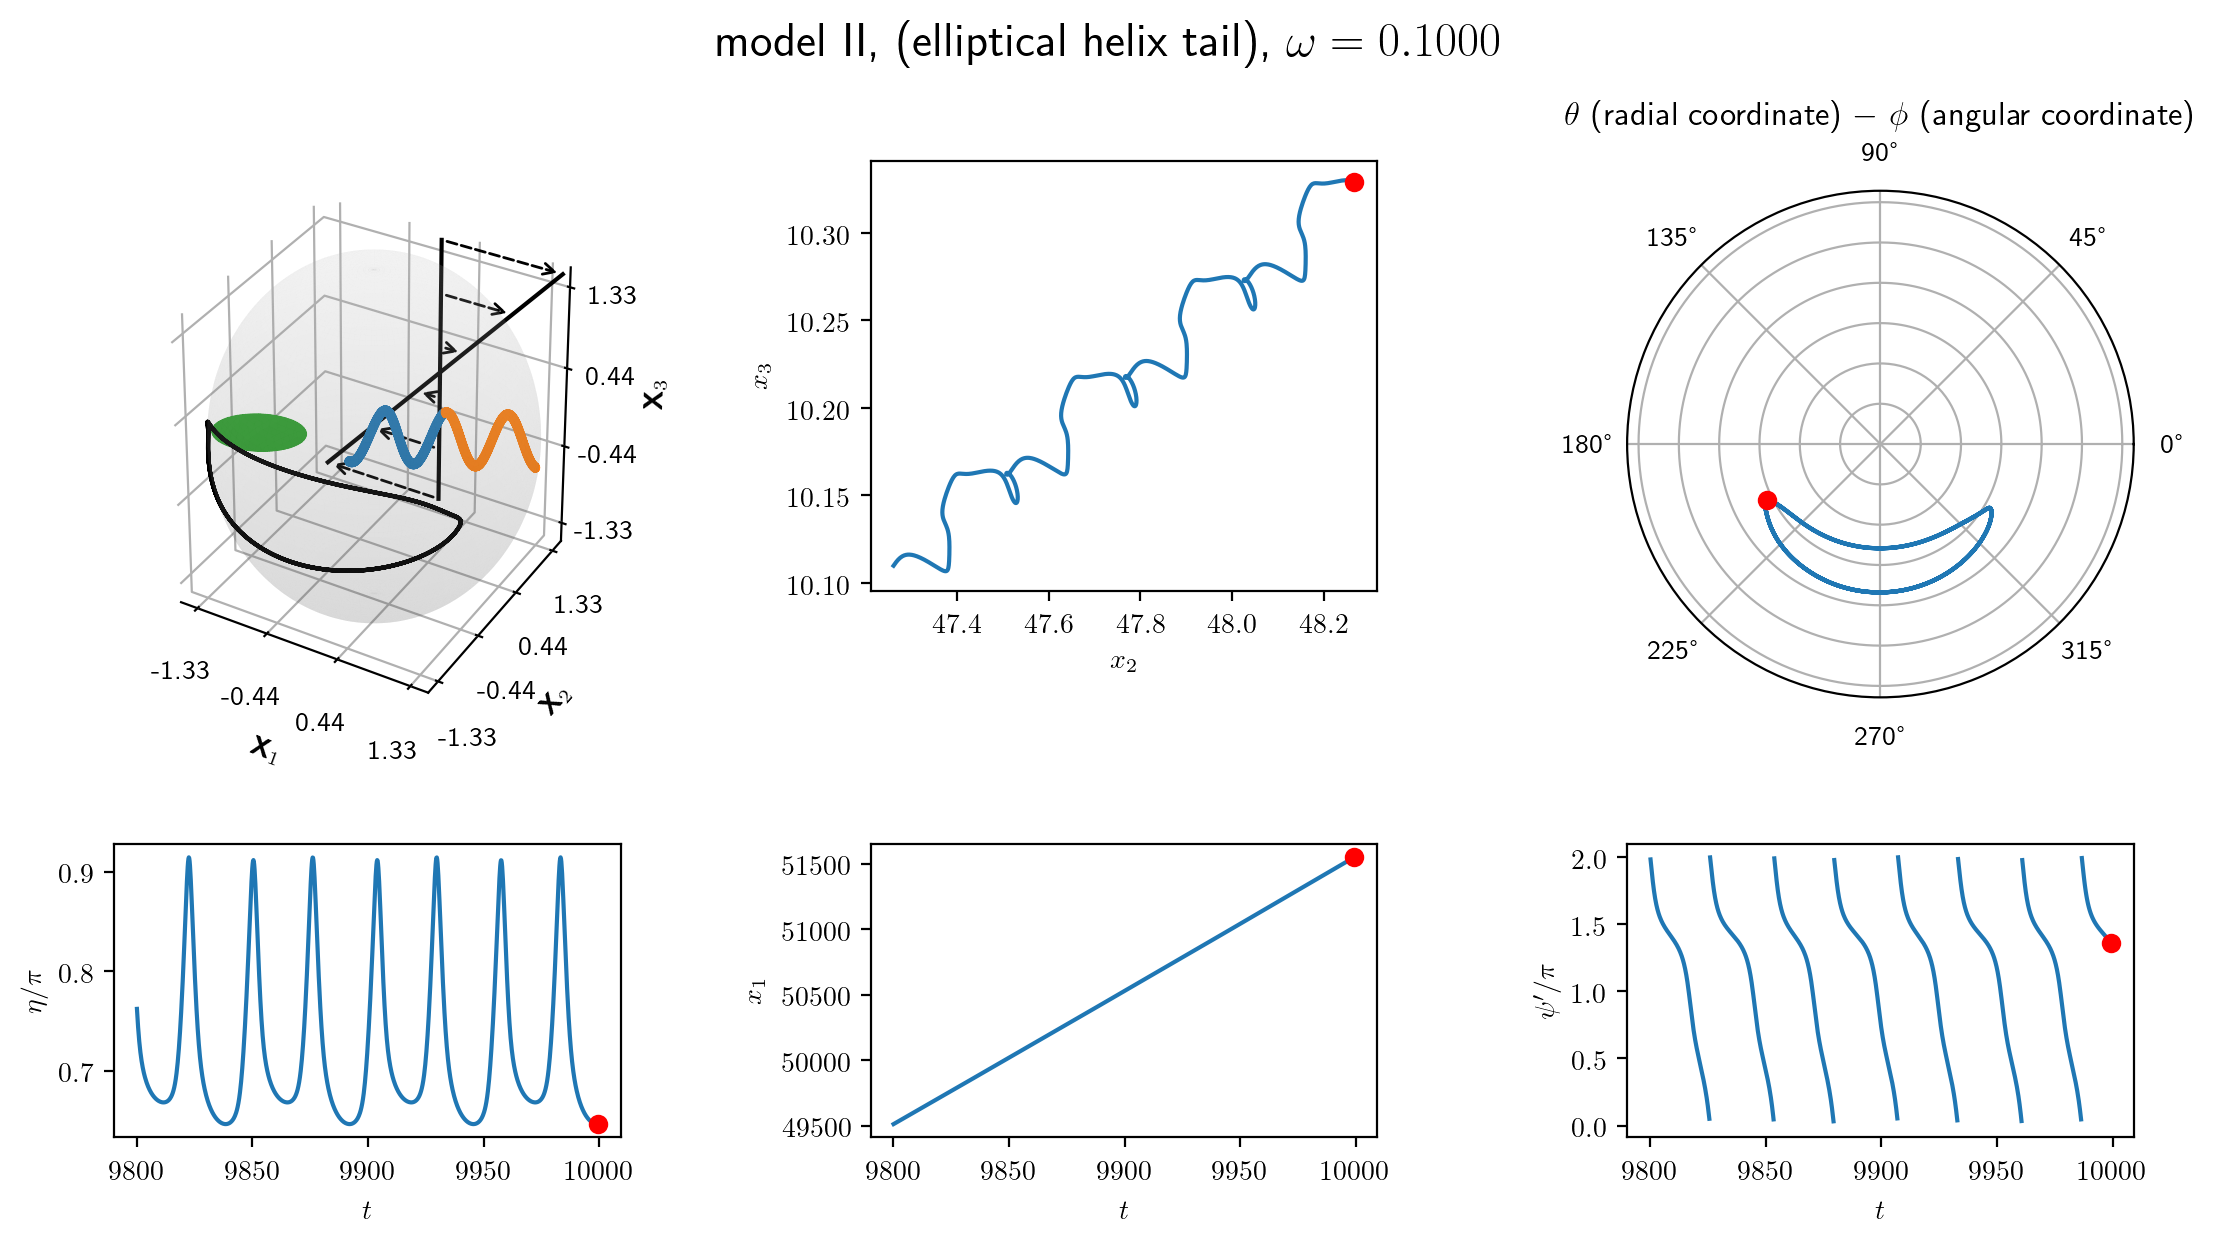

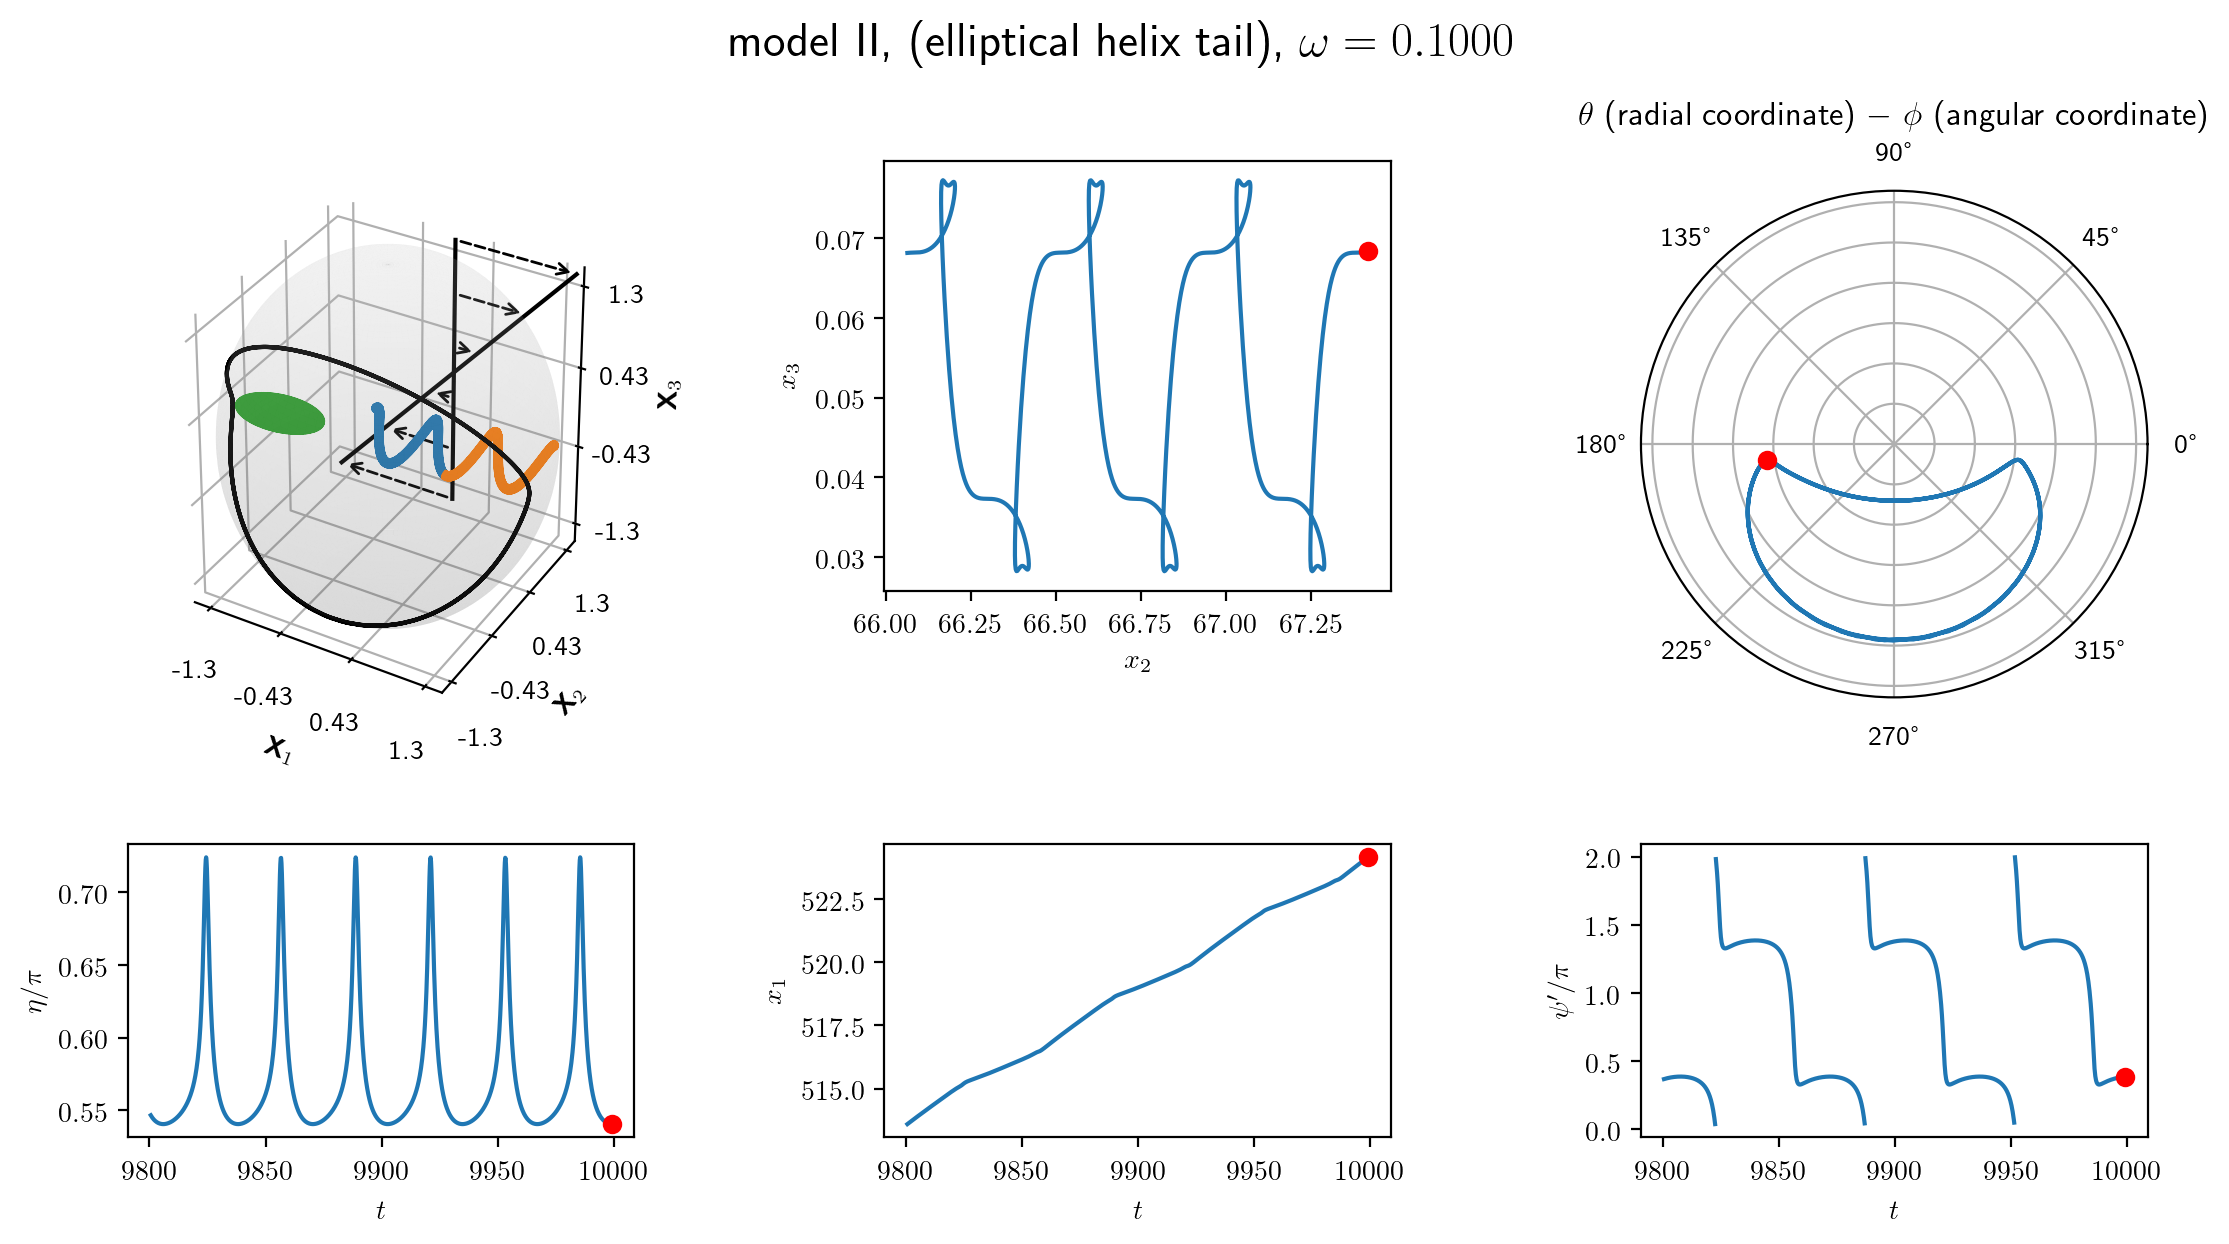

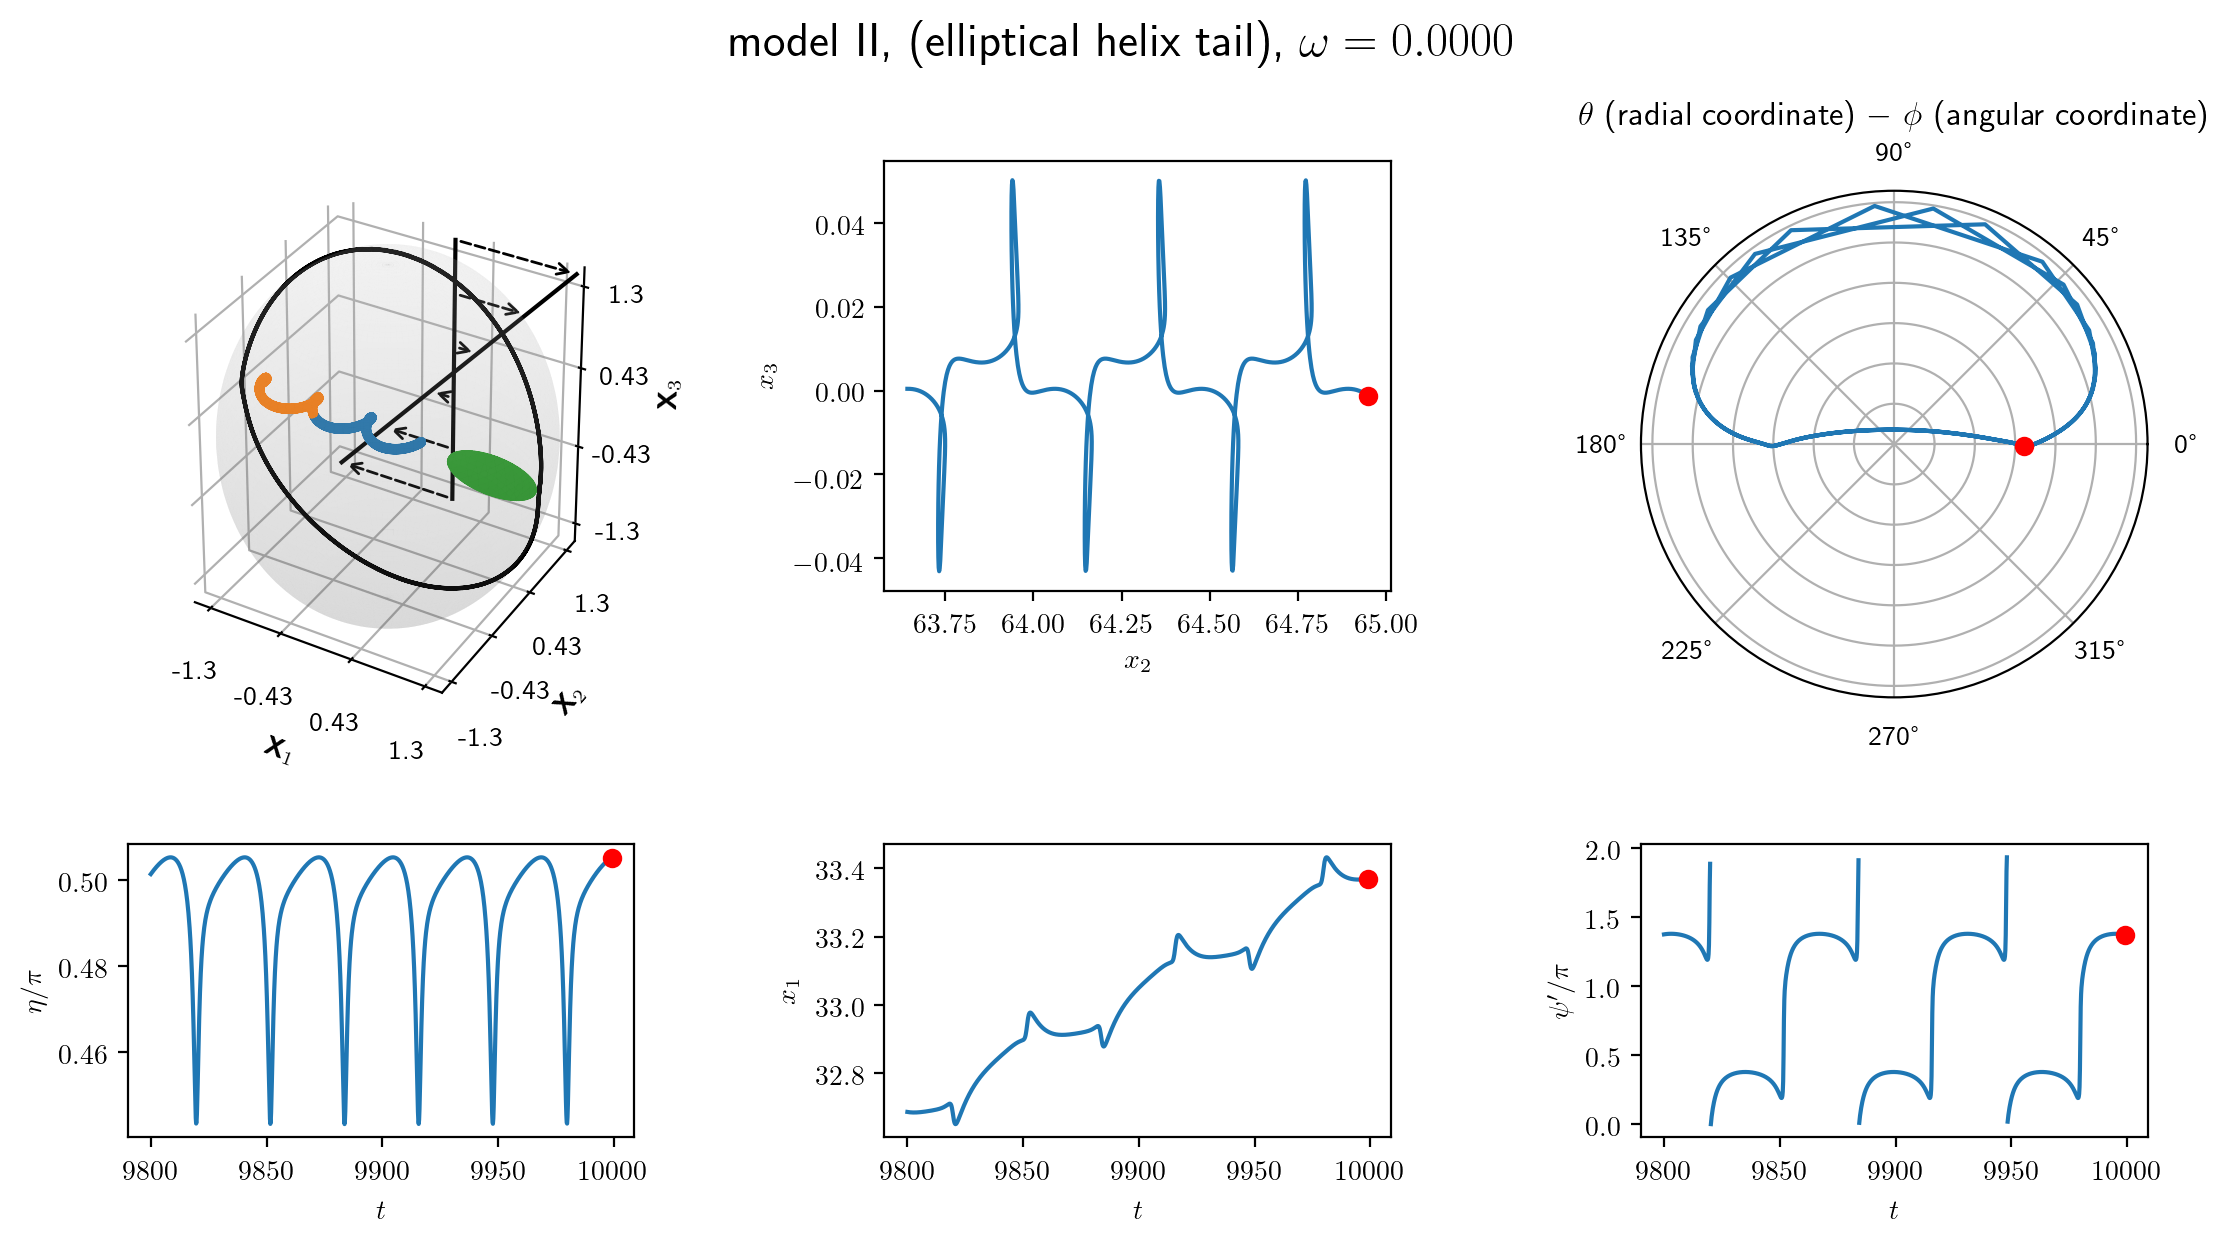

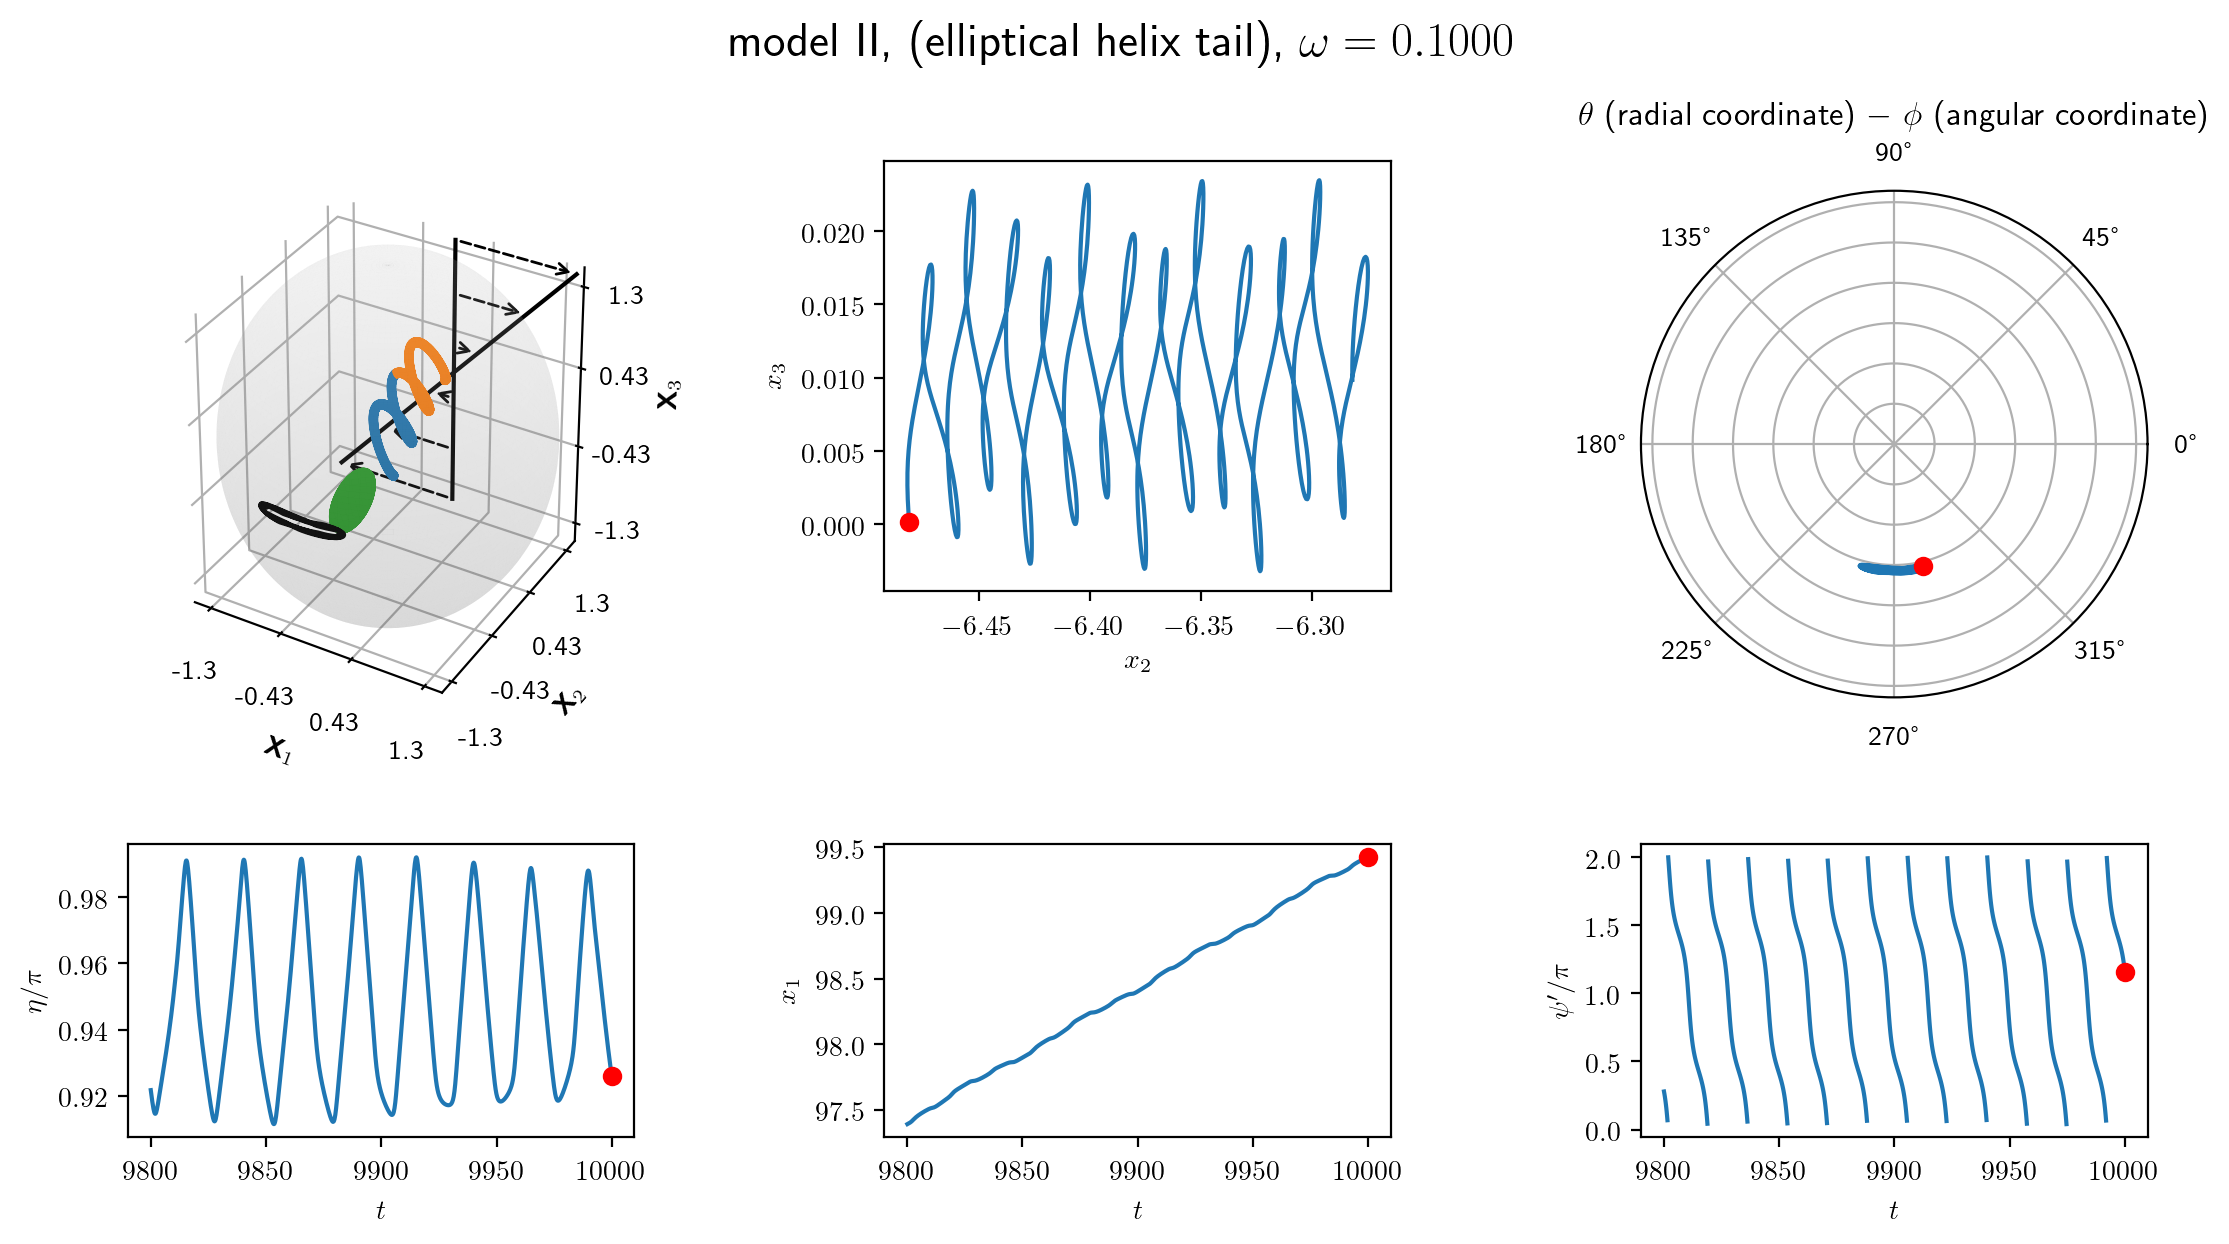

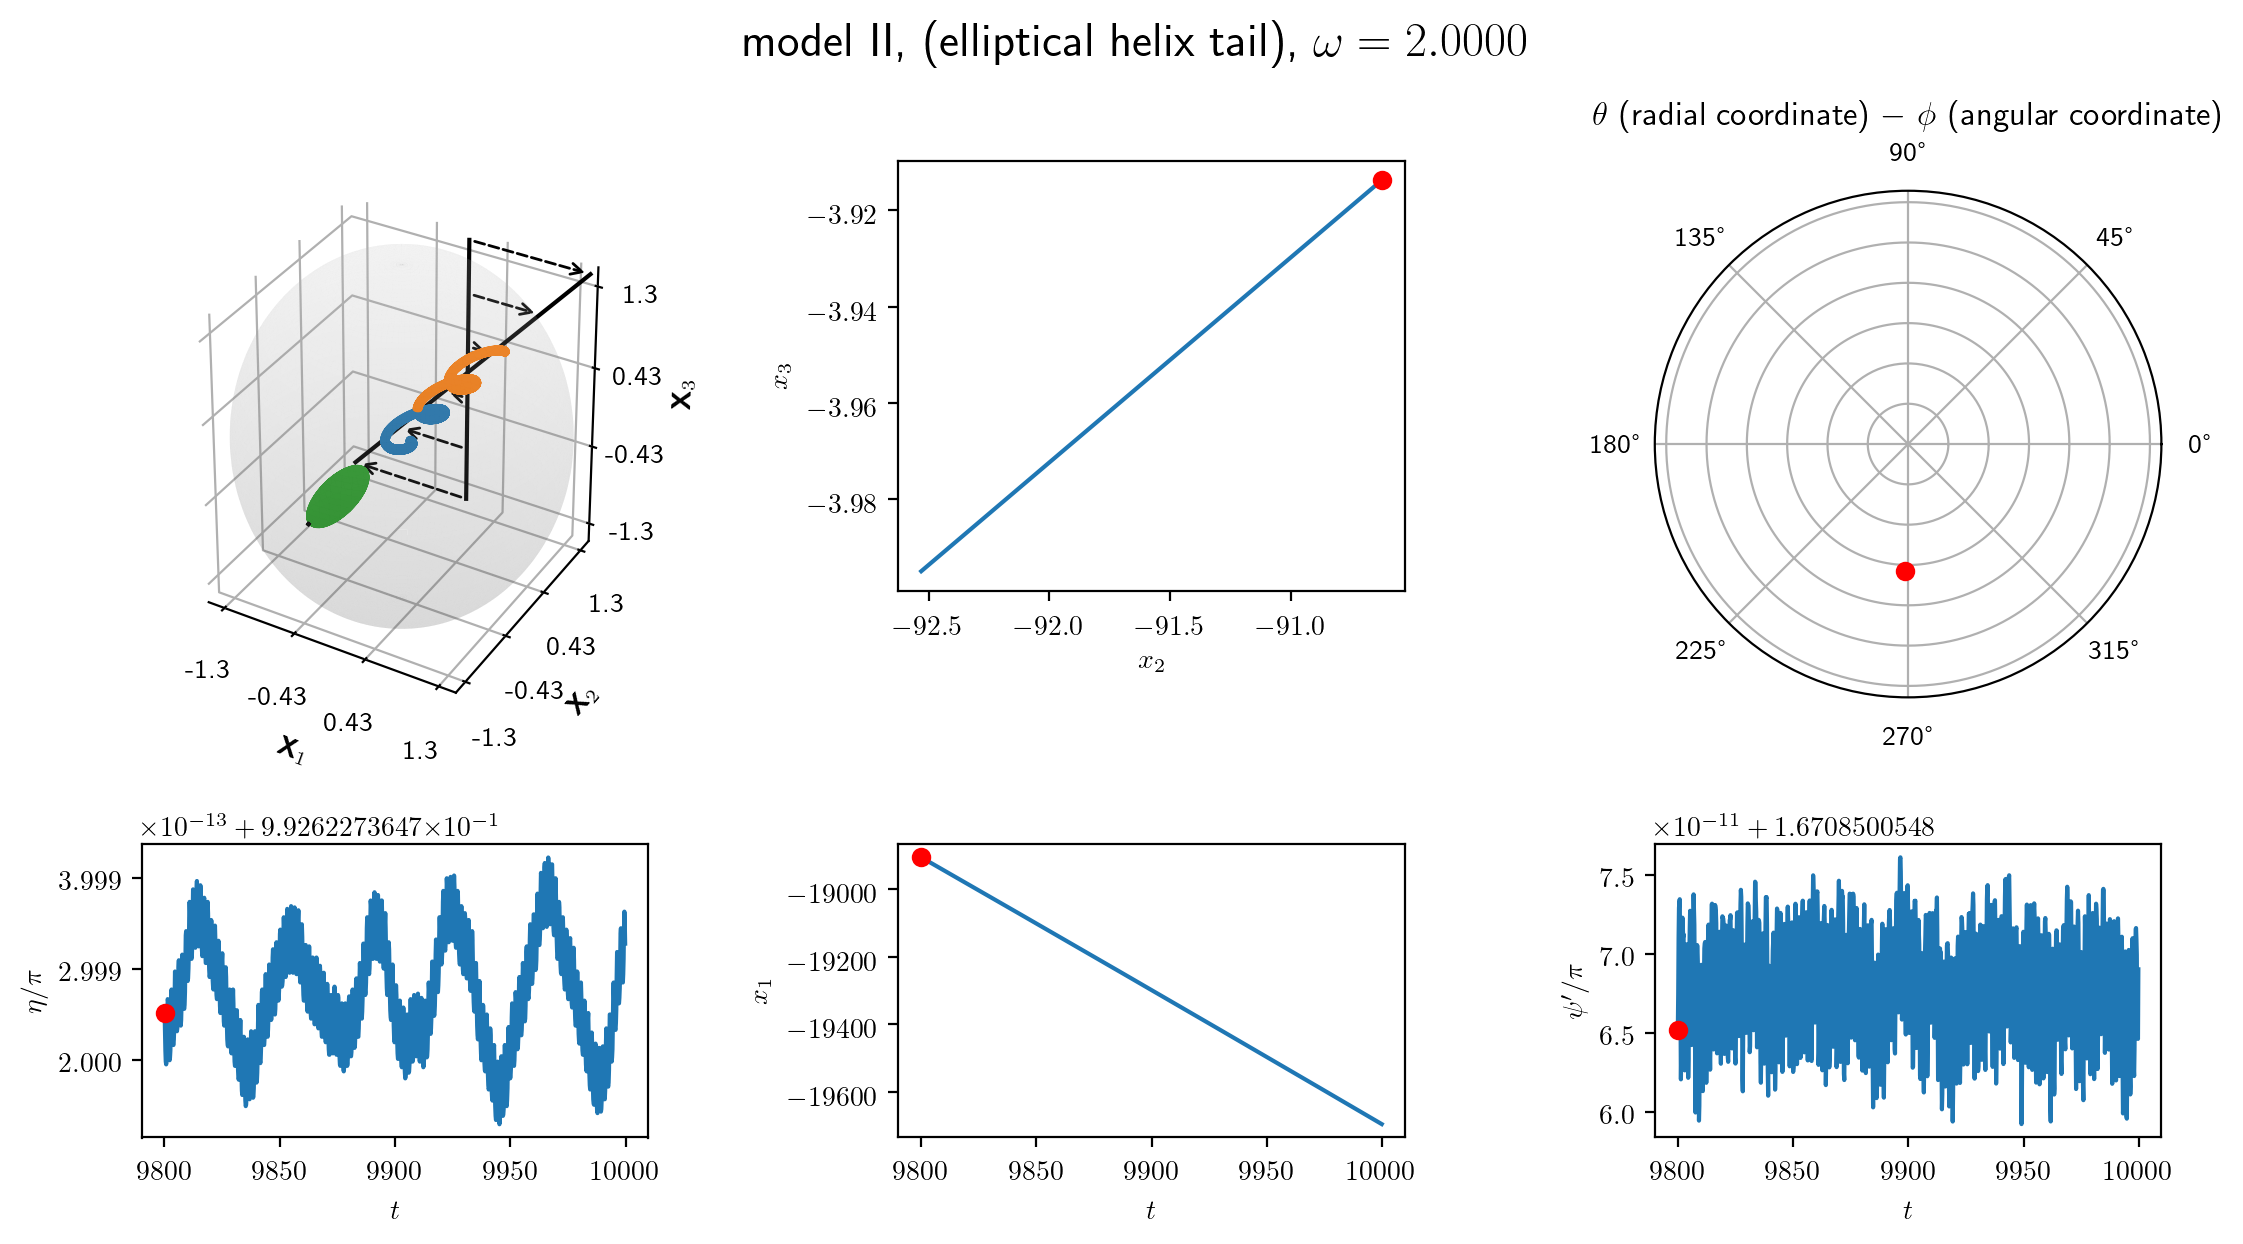

In [43]:
%matplotlib inline
from shutil import copyfile
from src.objComposite import *

figsize=np.array((16, 9))*0.7
dpi = 200
tmin = 9800
create_obj_at_fun=get_ecoli_nodes_split_at
extFlow = spf_tb.ext_simple_shear_flow
resampling_fct = 5
video_duration = 60
total_frame = video_duration * 20
dbg_mode = False
# dbg_mode = 2

# head_center = True
# info_list = []
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle'
# save_name = 'ecoC01B05_stuck_0.43'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle'
# save_name = 'ecoC01B05_stuck_0.89'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g/th2.17428_ph5.98741_ps3.66493/omega_tail00.81259_th2.174_ph5.987_ps3.665_D20200812_T210328.pickle'
# save_name = 'ecoC01B05_stuck_1.43'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle'
# save_name = 'ecoC01B05_stuck_1.89'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# # 
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_w0_psi_rada_a_00.pickle'
# save_name = 'ecoB01B05_I1'
# suptitle_handle = 'model I, (circular helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_w2_psi_rada_b_00.pickle'
# save_name = 'ecoB01B05_I2'
# suptitle_handle = 'model I, (circular helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# # 
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c1_00.pickle'
# save_name = 'ecoC01B05_II0'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c2_00.pickle'
# save_name = 'ecoC01B05_II1'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c3_00.pickle'
# save_name = 'ecoC01B05_II2a'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d2_00.pickle'
# save_name = 'ecoC01B05_II2b'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d3_00.pickle'
# save_name = 'ecoC01B05_II2c'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c4_00.pickle'
# save_name = 'ecoC01B05_II3'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d1_00.pickle'
# save_name = 'ecoC01B05_II4a'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt2_psi_rada_e_00.pickle'
# save_name = 'ecoC01B05_II4b'
# suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
# info_list.append((tpath, save_name, suptitle_handle))
# # display(info_list)
# # assert 1 == 2

head_center = False
info_list = []
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle'
save_name = 'ecoC01B05_stuck_0.43_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle'
save_name = 'ecoC01B05_stuck_0.89_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g/th2.17428_ph5.98741_ps3.66493/omega_tail00.81259_th2.174_ph5.987_ps3.665_D20200812_T210328.pickle'
save_name = 'ecoC01B05_stuck_1.43_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle'
save_name = 'ecoC01B05_stuck_1.89_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
# 
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_w0_psi_rada_a_00.pickle'
save_name = 'ecoB01B05_I1_bodyC'
suptitle_handle = 'model I, (circular helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoB01B05_w2_psi_rada_b_00.pickle'
save_name = 'ecoB01B05_I2_bodyC'
suptitle_handle = 'model I, (circular helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
# 
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c1_00.pickle'
save_name = 'ecoC01B05_II0_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c2_00.pickle'
save_name = 'ecoC01B05_II1_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c3_00.pickle'
save_name = 'ecoC01B05_II2a_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d2_00.pickle'
save_name = 'ecoC01B05_II2b_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d3_00.pickle'
save_name = 'ecoC01B05_II2c_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_passive_psi_rada_c4_00.pickle'
save_name = 'ecoC01B05_II3_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt0.1_psi_rada_d1_00.pickle'
save_name = 'ecoC01B05_II4a_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/MOVIE/ecoC01B05_wt2_psi_rada_e_00.pickle'
save_name = 'ecoC01B05_II4b_bodyC'
suptitle_handle = 'model II, (elliptical helix tail), $\\omega=%.4f$'
info_list.append((tpath, save_name, suptitle_handle))

for tpath, save_name, suptitle_handle in info_list:
    print(tpath)
    with open(tpath, 'rb') as handle:
        tpick = pickle.load(handle)
    Table_t = tpick['Table_t']
    Table_dt = tpick['Table_dt']
    Table_X = tpick['Table_X']
    Table_P = tpick['Table_P']
    Table_P2 = tpick['Table_P2']
    Table_theta = tpick['Table_theta']
    Table_phi = tpick['Table_phi']
    Table_psi = tpick['Table_psi']
    Table_eta = tpick['Table_eta']
    table_path = os.path.join('/home/zhangji/stokes_flow_master/src', 
                              '%s.pickle' % tpick['problem_kwargs']['table_name'])
    with open(table_path, 'rb') as handle:
        table_path = pickle.load(handle)
    problem_kwargs = table_path['problem_kwargs']
    suptitle = suptitle_handle % tpick['problem_kwargs']['omega_tail']

    tidx = Table_t > tmin
    anim, t1 = spf_tb.make_table_video_geo_v2(Table_t[tidx], Table_X[tidx], Table_P[tidx], Table_P2[tidx],
                                              Table_theta[tidx], Table_phi[tidx], Table_psi[tidx], Table_eta[tidx],
                                              stp=1, interval=-1, trange_geo=None, trange_trj=None, 
                                              create_obj_at_fun=create_obj_at_fun, resampling_fct=resampling_fct, 
                                              dbg_mode=dbg_mode, figsize=figsize, dpi=dpi, 
                                              suptitle=suptitle, extFlow=extFlow, add_info=True, 
                                              video_duration=video_duration, total_frame=total_frame, 
                                              head_center=head_center, 
                                              **problem_kwargs)
    frames = t1[0]
    tname = os.path.join(os.getcwd(), 'MOVIE', '%s.pickle' % save_name)
    copyfile(tpath, tname)
    tname = os.path.join(os.getcwd(), 'MOVIE', '%s.mp4' % save_name)
    anim.save(tname, writer='ffmpeg', fps=frames/video_duration)
    print(datetime.now(), 'save to %s' % tname)
    print()

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle
trange_geo= 1.4393947720186036


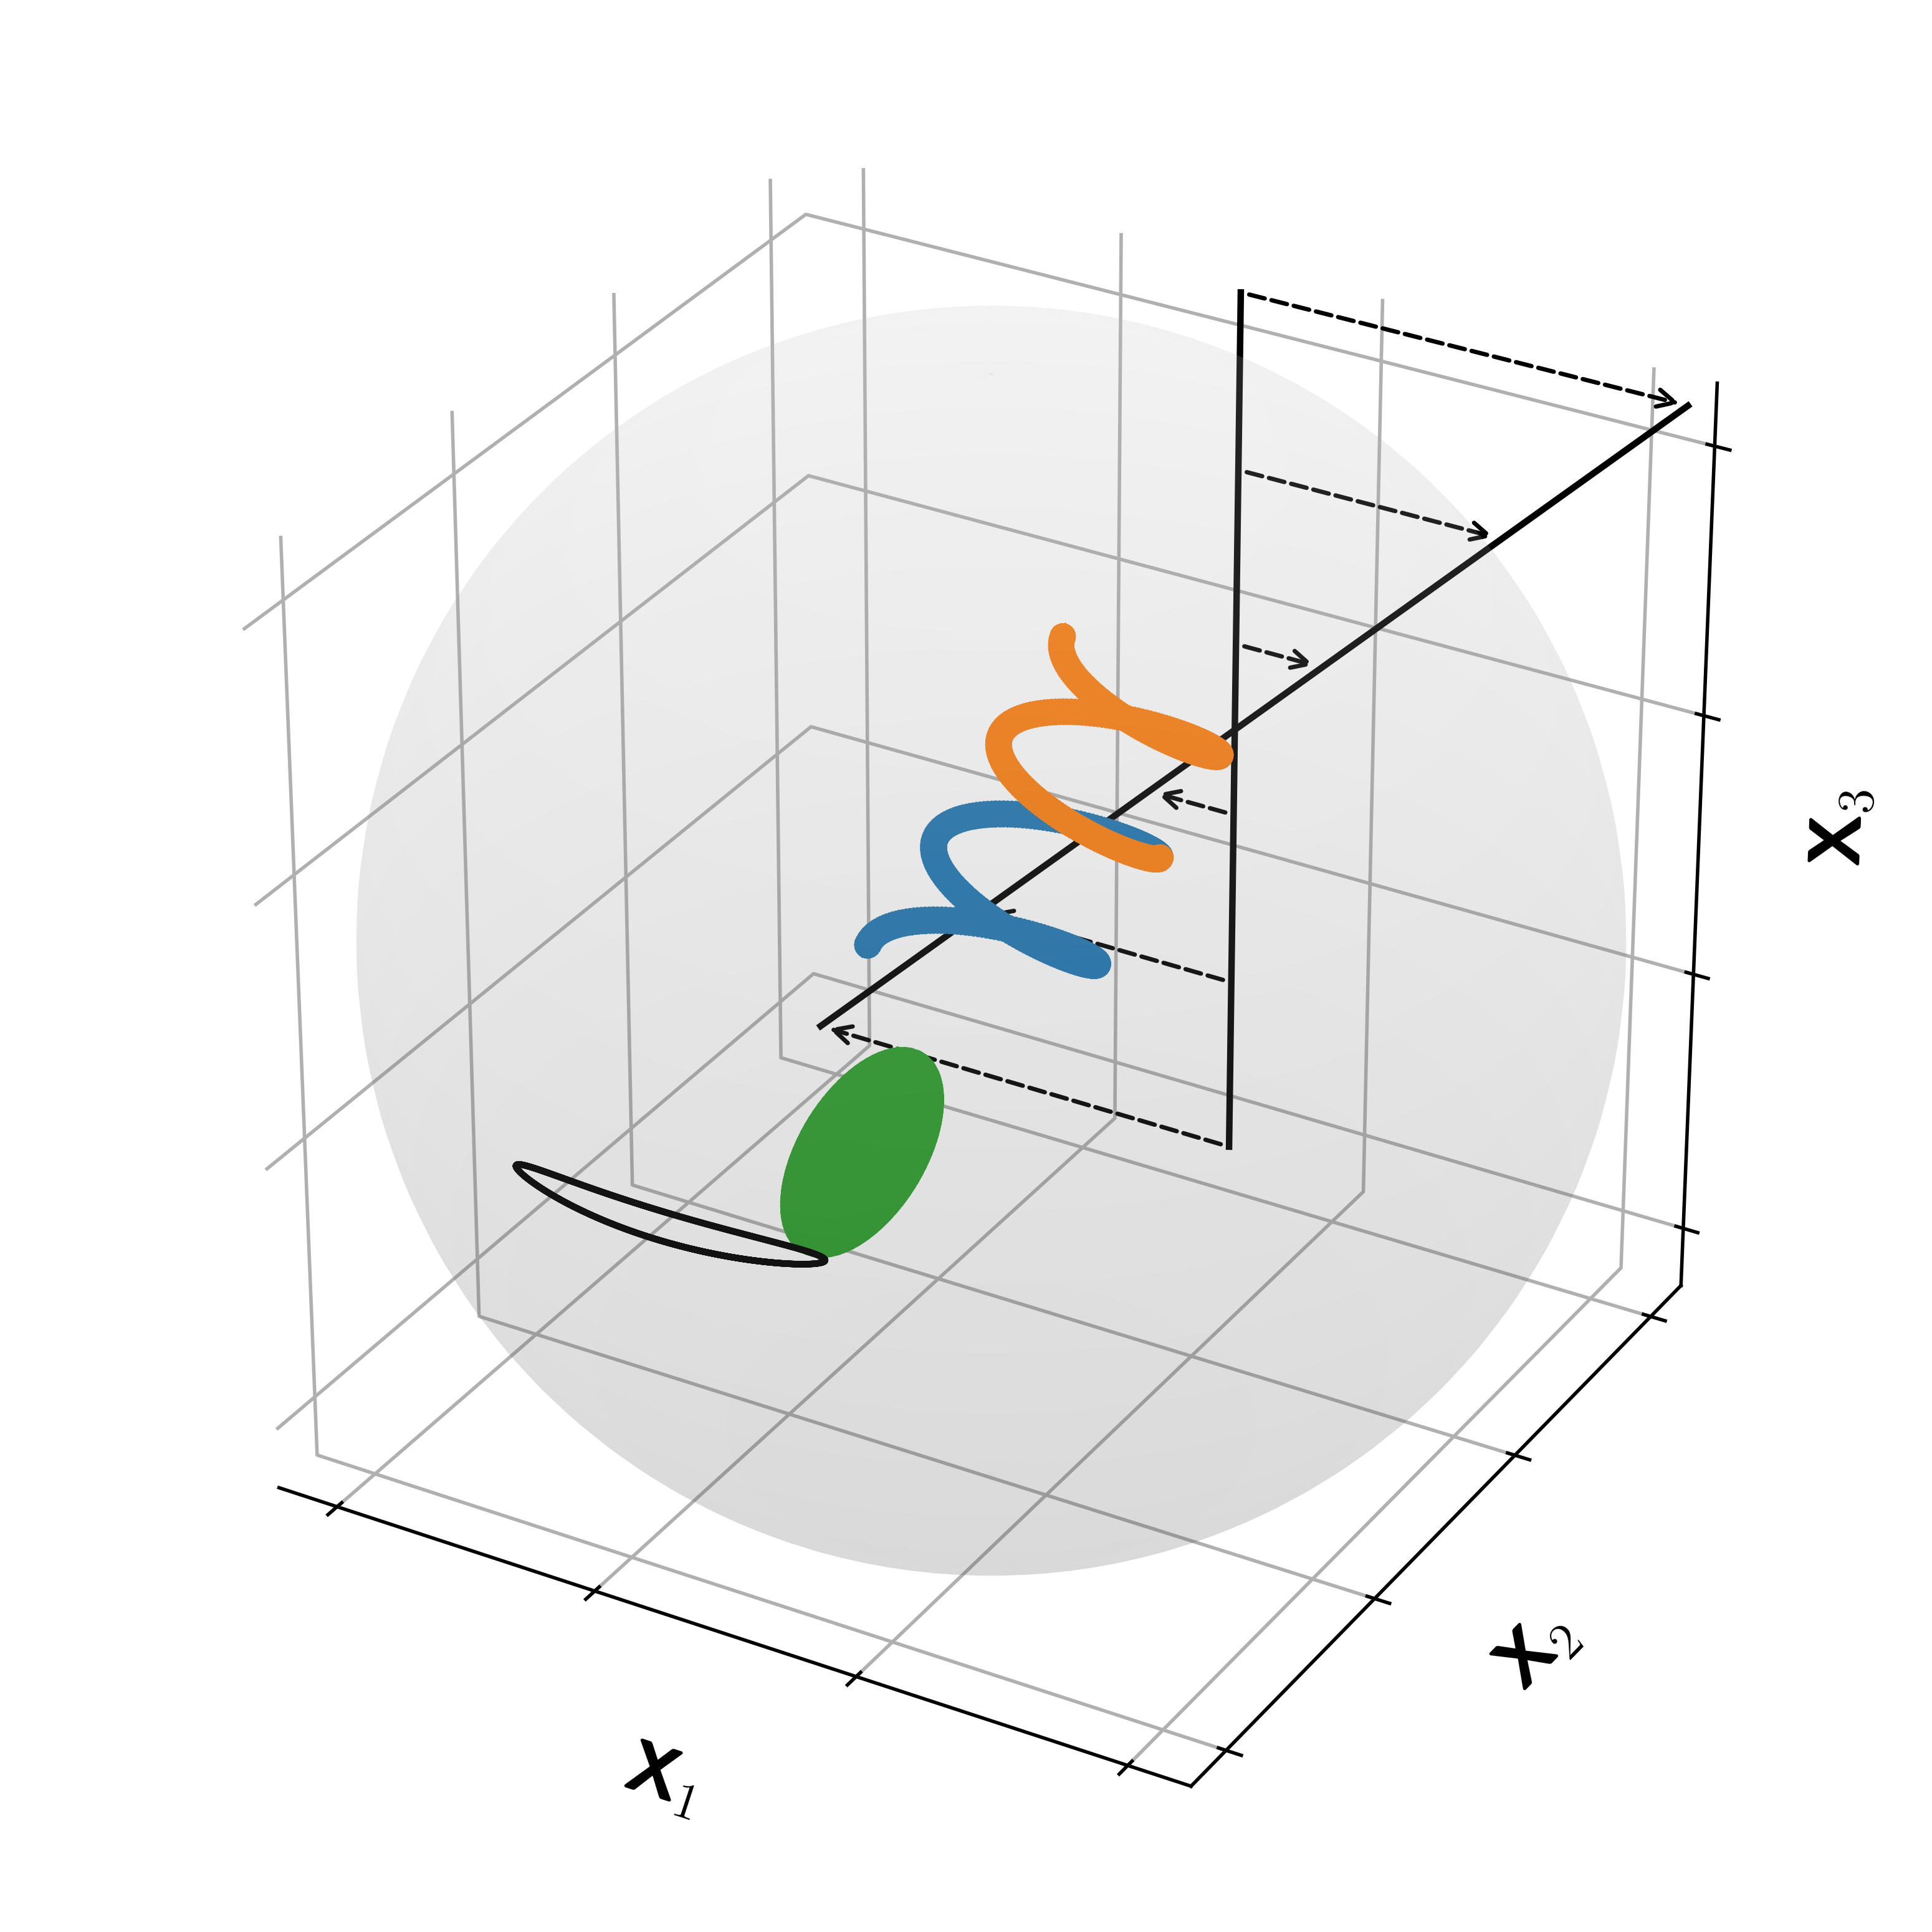

In [48]:
# %matplotlib notebook
%matplotlib inline

from src.objComposite import *
from matplotlib import colors as mcolors

figsize=np.array((9, 9))*0.7
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
tmin = 9800
create_obj_at_fun = get_ecoli_nodes_split_at
extFlow = spf_tb.ext_simple_shear_flow
trange_geo = None

tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g/th2.17428_ph5.98741_ps3.66493/omega_tail00.81259_th2.174_ph5.987_ps3.665_D20200812_T210328.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle'

print(tpath)
with open(tpath, 'rb') as handle:
    tpick = pickle.load(handle)
Table_t = tpick['Table_t']
tidx = Table_t > tmin
# 
Table_t = tpick['Table_t'][tidx]
Table_dt = tpick['Table_dt'][tidx]
Table_X = tpick['Table_X'][tidx]
Table_P = tpick['Table_P'][tidx]
Table_P2 = tpick['Table_P2'][tidx]
Table_theta = tpick['Table_theta'][tidx]
Table_phi = tpick['Table_phi'][tidx]
Table_psi = tpick['Table_psi'][tidx]
Table_eta = tpick['Table_eta'][tidx]
table_path = os.path.join('/home/zhangji/stokes_flow_master/src', 
                          '%s.pickle' % tpick['problem_kwargs']['table_name'])
with open(table_path, 'rb') as handle:
    table_path = pickle.load(handle)
problem_kwargs = table_path['problem_kwargs']
#
ttheta = Table_theta[0]
tphi = Table_phi[0]
tpsi = Table_psi[0]
# ttheta, tphi, tpsi = np.pi / 2, 3 * np.pi / 2, np.pi / 2

fig, axorin = plt.subplots(1, 1, figsize=figsize, dpi=dpi, subplot_kw=dict(projection='3d'))
fig.patch.set_facecolor('white')
for spine in axorin.spines.values():
    spine.set_visible(False)
axorin.set_xlabel('$\\textbf{X}_1$', fontsize='xx-large')
axorin.set_ylabel('$\\textbf{X}_2$', fontsize='xx-large')
axorin.set_zlabel('$\\textbf{X}_3$', fontsize='xx-large')
axorin.set_xticklabels([])
axorin.set_yticklabels([])
axorin.set_zticklabels([])
axorin.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axorin.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axorin.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
# object orientation
tnodes = create_obj_at_fun(ttheta, tphi, tpsi, now_center=np.zeros(3), **problem_kwargs)
if trange_geo is None:
    tnode = np.vstack(tnodes)
    trange_geo = np.linalg.norm(tnode.max(axis=0) - tnode.min(axis=0)) * 0.4
print('trange_geo=', trange_geo)
tmid = np.zeros(3)
axorin.set_xlim3d([tmid[0] - trange_geo, tmid[0] + trange_geo])
tticks = np.around(np.linspace(tmid[0] - trange_geo, tmid[0] + trange_geo, 21),
                   decimals=2)[1::6]
axorin.set_xticks(tticks)
# axorin.set_xticklabels(tticks)
axorin.set_ylim3d([tmid[1] - trange_geo, tmid[1] + trange_geo])
tticks = np.around(np.linspace(tmid[1] - trange_geo, tmid[1] + trange_geo, 21),
                   decimals=2)[1::6]
axorin.set_yticks(tticks)
# axorin.set_yticklabels(tticks)
axorin.set_zlim3d([tmid[2] - trange_geo, tmid[2] + trange_geo])
tticks = np.around(np.linspace(tmid[2] - trange_geo, tmid[2] + trange_geo, 21),
                   decimals=2)[1::6]
axorin.set_zticks(tticks)
# axorin.set_zticklabels(tticks)
extFlow(axorin, trange_geo=trange_geo, **problem_kwargs)
tmp_geo = []
for tnodei in tnodes:
    tmp_geo.append(axorin.plot(tnodei[:, 0], tnodei[:, 1], tnodei[:, 2])[0])
# Jeffery sphere
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
tr = np.linalg.norm(np.vstack(tnodes), axis=-1).max()
x = np.cos(u) * np.sin(v) * tr
y = np.sin(u) * np.sin(v) * tr
z = np.cos(v) * tr
color1 = plt.get_cmap('gray')(np.linspace(0.2, 0.8, 256))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', color1)
axorin.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cmap, edgecolor='none', alpha=0.1)
axorin.plot(Table_P[:, 0] * tr, Table_P[:, 1] * tr, Table_P[:, 2] * tr, 'k')
plt.tight_layout()

<IPython.core.display.Javascript object>


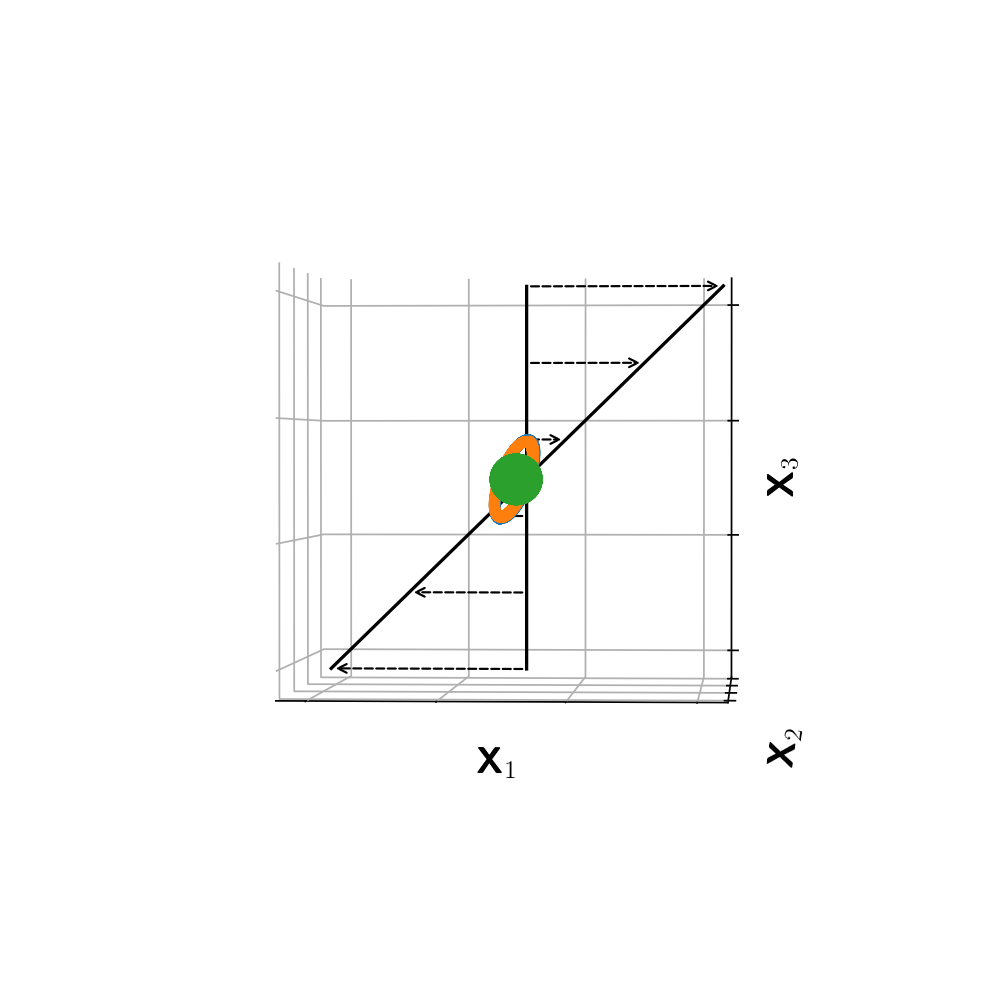

In [34]:
fig

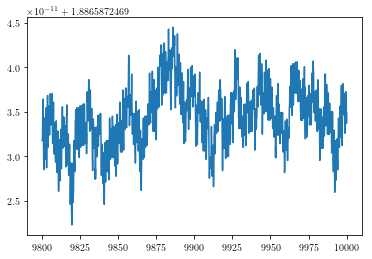

In [22]:
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle'
figsize=np.array((16, 9)) * 1
dpi=400

with open(tpath, 'rb') as handle:
    tpick = pickle.load(handle)
Table_t = tpick['Table_t']
Table_dt = tpick['Table_dt']
Table_X = tpick['Table_X']
Table_P = tpick['Table_P']
Table_P2 = tpick['Table_P2']
Table_theta = tpick['Table_theta']
Table_phi = tpick['Table_phi']
Table_psi = tpick['Table_psi']
Table_eta = tpick['Table_eta']
idx = Table_t > 9800
# spf_tb.show_table_result_v2(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                             Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], 
#                             figsize=figsize, dpi=dpi)
plt.plot(Table_t[idx], Table_psi[idx] / np.pi)